# Computer Assignment 4: CNN Segmentation
## Alaqian Zafar - aaz7118

## Table of Contents
- <a href='#p1a'>Part (a)</a>
- <a href='#p1b'>Part (b)</a>
- <a href='#p1c'>Part (c)</a>
    - [Architecture](#Architecture)
    - [Loss Function](#Loss-Function)
- <a href='#p1d'>Part (d)</a>
- <a href='#p2a'>Part (e)</a>
- <a href='#p2b'>Part (f)</a>
- <a href='#p2c'>Part (g)</a>

In [1]:
import os
import random

import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import transforms
from tqdm import tqdm

%matplotlib inline

In [2]:
try:
    from google.colab import drive
    drive.mount('/content/drive')
    path = '/content/drive/MyDrive/ECE-GY 6123 Image and Video Processing/Computer Assignments/CA04/archive'
except:
    path = 'archive'

<a id='p1a'></a>
##### (a) Cut the FudanPed dataset into an 80-10-10 train-val-test split.

[Table of Contents](#Table-of-Contents)

In [3]:
image_paths = sorted([os.path.join(path, "PNGImages", image) for image in os.listdir(os.path.join(path, "PNGImages"))])
mask_paths = sorted([os.path.join(path, "PedMasks", mask) for mask in os.listdir(os.path.join(path, "PedMasks"))])

indices = list(range(len(image_paths)))
train_indices = random.sample(indices, k=int(len(indices)*0.8))
val_indices = random.sample(set(indices)-set(train_indices), k=int(len(indices)*0.1))
test_indices = list(set(indices)-set(train_indices)-set(val_indices))

train_image_paths = [image_paths[i] for i in train_indices]
train_mask_paths = [mask_paths[i] for i in train_indices]
val_image_paths = [image_paths[i] for i in val_indices]
val_mask_paths = [mask_paths[i] for i in val_indices]
test_image_paths = [image_paths[i] for i in test_indices]
test_mask_paths = [mask_paths[i] for i in test_indices]

class PennFudanDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = cv2.imread(self.image_paths[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_paths[idx], 0)
        # Set all values greater-than or equal-to 1 to 255.
        mask = np.clip(mask, 0, 1)*255
        merged_image = np.concatenate((image, mask[:, :, None]), axis=2)
        merged_image = transforms.ToTensor()(merged_image)
        if self.transform:
            merged_image = self.transform(merged_image)
        image = merged_image[:3, :, :]
        mask = merged_image[3, :, :]
        return image, mask

<a id='p1b'></a>
##### (b) Apply data augmentation to your dataset during training and show an example of your data augmentation in your report.

[Table of Contents](#Table-of-Contents)

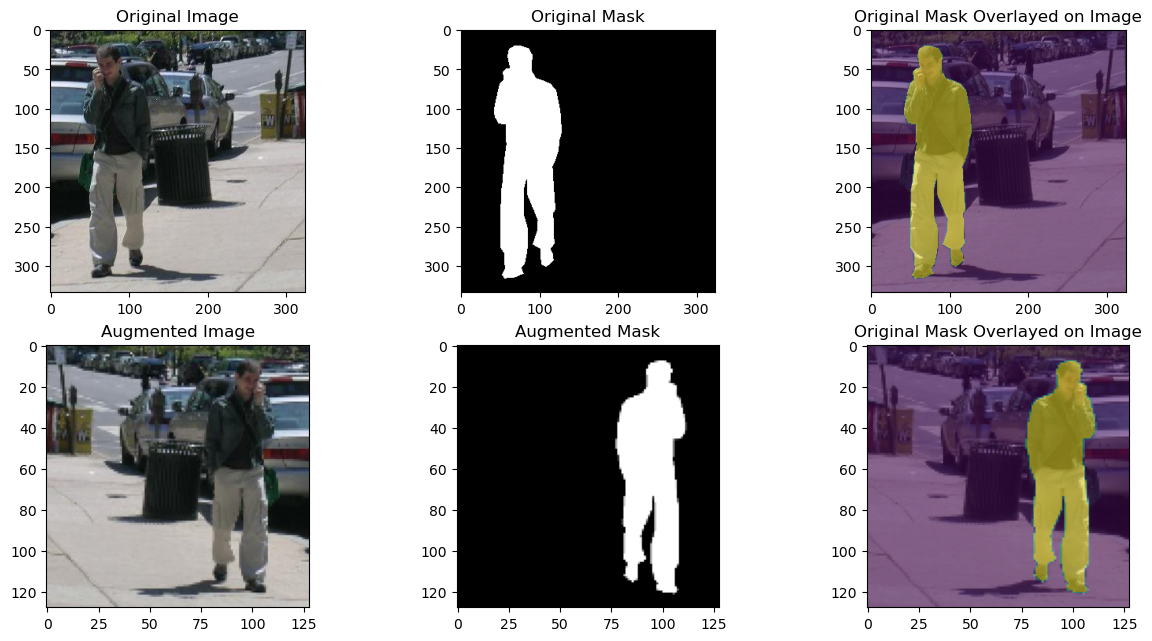

In [4]:
# Plot a subplot of the original and the augmented image and mask
train_dataset = PennFudanDataset(train_image_paths, train_mask_paths)
image, mask = train_dataset[0]
fig, ax = plt.subplots(2, 3, figsize=(15, 7.5))
ax[0,0].imshow(image.permute(1, 2, 0))
ax[0,0].set_title("Original Image")
ax[0,1].imshow(mask, cmap="gray")
ax[0,1].set_title("Original Mask")
ax[0,2].imshow(image.permute(1, 2, 0))
ax[0,2].imshow(mask, alpha=0.5)
ax[0,2].set_title("Original Mask Overlayed on Image")

image_size = (128,128)
augmentation = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.Resize(image_size)
    ])
augmented_train_dataset = PennFudanDataset(train_image_paths, train_mask_paths, transform=augmentation)
image, mask = augmented_train_dataset[0]
ax[1,0].imshow(image.permute(1, 2, 0))
ax[1,0].set_title("Augmented Image")
ax[1,1].imshow(mask, cmap="gray")
ax[1,1].set_title("Augmented Mask")
ax[1,2].imshow(image.permute(1, 2, 0))
ax[1,2].imshow(mask, alpha=0.5)
ax[1,2].set_title("Original Mask Overlayed on Image")

batchsize = 8

train_loader = DataLoader(augmented_train_dataset, batch_size=batchsize, shuffle=True)
test_dataset = PennFudanDataset(
    test_image_paths,
    test_mask_paths, 
    transform=transforms.Resize(image_size))
test_loader = DataLoader(test_dataset, batch_size=batchsize, shuffle=False)
val_dataset = PennFudanDataset(
    val_image_paths, 
    val_mask_paths, 
    transform=transforms.Resize(image_size))
val_loader = DataLoader(test_dataset, batch_size=batchsize, shuffle=False)

<a id='p1c'></a>
##### (c) Implement and train a CNN for binary segmentation on your train split. Describe your network architecture, loss function, and any training hyper-parameters. You may implement any architecture you'd like, **but the implementation must be your own code.**

[Table of Contents](#Table-of-Contents)

#### Architecture

`x` (input) → `Conv_BN_ReLU1` → `Downsample1` → `x1` → `x2` → `Conv_BN_ReLU2` → `x3` → `Downsample2` → `x4` → `Conv_BN_ReLU3` → `x5` → `Upsample1` → `x6` → `cat(x3)` → `x7` → `Conv_BN_ReLU4` → `x8` → `Upsamle2` → `x9` → `cat(x1)` → `x10` → `Conv_BN_ReLU5` → `x11` → `conv6` → `x12` → `sigmoid` → `x13` (output)

![Architecture](UNET.png)

In [5]:
class UNET(nn.Module):
    def __init__(self):
        super(UNET, self).__init__()
        self.Conv_BN_ReLU1 = self._Conv_BN_ReLU(3, 16)
        self.Downsample1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Conv_BN_ReLU2 = self._Conv_BN_ReLU(16, 32)
        self.Downsample2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Conv_BN_ReLU3 = self._Conv_BN_ReLU(32, 32)
        self.Upsample1 = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.Conv_BN_ReLU4 = self._Conv_BN_ReLU(64, 16)
        self.Upsample2 = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.Conv_BN_ReLU5 = self._Conv_BN_ReLU(32, 16)
        self.Conv6 = nn.Conv2d(16, 1, kernel_size=1)

    def _Conv_BN_ReLU(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding='same'),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding='same'),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        x1 = self.Conv_BN_ReLU1(x) # 3x128x128 -> 16x128x128
        x2 = self.Downsample1(x1) # 16x128x128 -> 16x64x64
        x3 = self.Conv_BN_ReLU2(x2) # 16x64x64 -> 32x64x64
        x4 = self.Downsample2(x3) # 32x64x64 -> 32x32x32
        x5 = self.Conv_BN_ReLU3(x4) # 32x32x32 -> 32x32x32\
        x6 = self.Upsample1(x5) # 32x32x32 -> 32x64x64
        x7 = torch.cat((x6, x3), dim=1) # 32x64x64 + 32x64x64 -> 64x64x64
        x8 = self.Conv_BN_ReLU4(x7) # 64x64x64 -> 16x64x64
        x9 = self.Upsample2(x8) # 16x64x64 -> 16x128x128
        x10 = torch.cat((x9, x1), dim=1) # 16x128x128 + 16x128x128 -> 32x128x128
        x11 = self.Conv_BN_ReLU5(x10) # 32x128x128 -> 16x128x128
        x12 = self.Conv6(x11) # 16x128x128 -> 1x128x128
        x13 = torch.sigmoid(x12) # 1x128x128 -> 1x128x128
        return x13

#### Loss Function

[Table of Contents](#Table-of-Contents)

In [6]:
def dice_coefficient(pred, target):
    smooth = 1.
    pred = pred.view(-1)
    target = target.view(-1)
    intersection = (pred * target).sum()
    return (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)

class SoftDiceLoss(nn.Module):
    def __init__(self):
        super(SoftDiceLoss, self).__init__()
    
    def forward(self, pred, target):
        smooth = 1.
        pred = pred.view(-1)
        target = target.view(-1)
        intersection = (pred * target).sum()
        return 1 - (2. * intersection + smooth) / ((pred ** 2).sum() + (target ** 2).sum() + smooth)

#### Training

[Table of Contents](#Table-of-Contents)

In [7]:
def save_checkpoint(filename, model, optimizer, epoch, val_loss):
    torch.save({
        "model": model.state_dict(),
        "optimizer": optimizer.state_dict(),
        "epoch": epoch,
        "loss": val_loss}, filename)
    
def load_checkpoint(filename, model, optimizer):
    checkpoint = torch.load(filename)
    model.load_state_dict(checkpoint["model"])
    optimizer.load_state_dict(checkpoint["optimizer"])
    epoch = checkpoint["epoch"]
    loss = checkpoint["loss"]
    return model, optimizer, epoch, loss

def train(model, train_loader, optimizer, criterion, device):
    model.train()
    train_loss = 0
    for image, mask in train_loader:
        image = image.to(device)
        mask = mask.to(device)
        optimizer.zero_grad()
        pred = model(image)
        loss = criterion(pred, mask[:,None,:,:])
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    return train_loss / len(train_loader)

def evaluate(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for image, mask in val_loader:
            image = image.to(device)
            mask = mask.to(device)
            pred = model(image)
            loss = criterion(pred, mask[:,None,:,:])
            val_loss += loss.item()
    return val_loss / len(val_loader)


NUM_EPOCHS = 1000
learning_rate=0.001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNET().to(device)
criterion = SoftDiceLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
checkpoint_dir = "./checkpoints"
checkpoint_path = os.path.join(checkpoint_dir, "checkpoint.pth")

if os.path.exists(checkpoint_path):
    model, optimizer, start_epoch, val_loss = load_checkpoint(checkpoint_path, model, optimizer)
    print("Checkpoint loaded: start epoch = {}, val loss = {}".format(start_epoch, val_loss))
else:
    start_epoch = 0
    val_loss = np.inf

train_losses = []
val_losses = []
for epoch in range(start_epoch, start_epoch+NUM_EPOCHS):
    progress_bar = tqdm(train_loader)
    train_loss = train(model, progress_bar, optimizer, criterion, device)
    val_loss = evaluate(model, val_loader, criterion, device)
    print("Epoch: {}/{}...".format(epoch+1, start_epoch+NUM_EPOCHS),
            "Train Loss: {:.4f}...".format(train_loss),
            "Val Loss: {:.4f}".format(val_loss))
    train_losses.append(train_loss)
    val_losses.append(val_loss)
save_checkpoint(checkpoint_path, model, optimizer, epoch, val_loss)


100%|██████████| 17/17 [00:05<00:00,  2.94it/s]


Epoch: 1/1000... Train Loss: 0.5317... Val Loss: 0.6669


100%|██████████| 17/17 [00:05<00:00,  3.12it/s]


Epoch: 2/1000... Train Loss: 0.4632... Val Loss: 0.6107


100%|██████████| 17/17 [00:05<00:00,  3.16it/s]


Epoch: 3/1000... Train Loss: 0.4250... Val Loss: 0.4508


100%|██████████| 17/17 [00:05<00:00,  3.15it/s]


Epoch: 4/1000... Train Loss: 0.3848... Val Loss: 0.4242


100%|██████████| 17/17 [00:05<00:00,  3.23it/s]


Epoch: 5/1000... Train Loss: 0.3505... Val Loss: 0.3928


100%|██████████| 17/17 [00:05<00:00,  3.16it/s]


Epoch: 6/1000... Train Loss: 0.3281... Val Loss: 0.3651


100%|██████████| 17/17 [00:05<00:00,  3.20it/s]


Epoch: 7/1000... Train Loss: 0.3055... Val Loss: 0.3476


100%|██████████| 17/17 [00:05<00:00,  3.19it/s]


Epoch: 8/1000... Train Loss: 0.2838... Val Loss: 0.3475


100%|██████████| 17/17 [00:05<00:00,  3.21it/s]


Epoch: 9/1000... Train Loss: 0.2603... Val Loss: 0.2790


100%|██████████| 17/17 [00:05<00:00,  3.21it/s]


Epoch: 10/1000... Train Loss: 0.2612... Val Loss: 0.2596


100%|██████████| 17/17 [00:05<00:00,  3.21it/s]


Epoch: 11/1000... Train Loss: 0.2646... Val Loss: 0.3096


100%|██████████| 17/17 [00:05<00:00,  3.20it/s]


Epoch: 12/1000... Train Loss: 0.2428... Val Loss: 0.3069


100%|██████████| 17/17 [00:05<00:00,  3.22it/s]


Epoch: 13/1000... Train Loss: 0.2258... Val Loss: 0.2598


100%|██████████| 17/17 [00:05<00:00,  3.23it/s]


Epoch: 14/1000... Train Loss: 0.2126... Val Loss: 0.2434


100%|██████████| 17/17 [00:05<00:00,  3.18it/s]


Epoch: 15/1000... Train Loss: 0.2040... Val Loss: 0.2128


100%|██████████| 17/17 [00:05<00:00,  3.22it/s]


Epoch: 16/1000... Train Loss: 0.2103... Val Loss: 0.2480


100%|██████████| 17/17 [00:05<00:00,  3.22it/s]


Epoch: 17/1000... Train Loss: 0.2042... Val Loss: 0.2112


100%|██████████| 17/17 [00:05<00:00,  3.22it/s]


Epoch: 18/1000... Train Loss: 0.1853... Val Loss: 0.1899


100%|██████████| 17/17 [00:05<00:00,  3.16it/s]


Epoch: 19/1000... Train Loss: 0.1725... Val Loss: 0.2101


100%|██████████| 17/17 [00:05<00:00,  3.13it/s]


Epoch: 20/1000... Train Loss: 0.1719... Val Loss: 0.2145


100%|██████████| 17/17 [00:05<00:00,  3.12it/s]


Epoch: 21/1000... Train Loss: 0.1709... Val Loss: 0.1977


100%|██████████| 17/17 [00:05<00:00,  3.07it/s]


Epoch: 22/1000... Train Loss: 0.1671... Val Loss: 0.2807


100%|██████████| 17/17 [00:05<00:00,  3.10it/s]


Epoch: 23/1000... Train Loss: 0.1659... Val Loss: 0.1969


100%|██████████| 17/17 [00:05<00:00,  3.10it/s]


Epoch: 24/1000... Train Loss: 0.1580... Val Loss: 0.2019


100%|██████████| 17/17 [00:05<00:00,  3.03it/s]


Epoch: 25/1000... Train Loss: 0.1563... Val Loss: 0.1852


100%|██████████| 17/17 [00:05<00:00,  3.20it/s]


Epoch: 26/1000... Train Loss: 0.1532... Val Loss: 0.2208


100%|██████████| 17/17 [00:05<00:00,  3.28it/s]


Epoch: 27/1000... Train Loss: 0.1565... Val Loss: 0.2207


100%|██████████| 17/17 [00:05<00:00,  3.22it/s]


Epoch: 28/1000... Train Loss: 0.1476... Val Loss: 0.2398


100%|██████████| 17/17 [00:05<00:00,  3.02it/s]


Epoch: 29/1000... Train Loss: 0.1487... Val Loss: 0.1698


100%|██████████| 17/17 [00:05<00:00,  2.85it/s]


Epoch: 30/1000... Train Loss: 0.1381... Val Loss: 0.2143


100%|██████████| 17/17 [00:05<00:00,  3.31it/s]


Epoch: 31/1000... Train Loss: 0.1452... Val Loss: 0.1940


100%|██████████| 17/17 [00:05<00:00,  3.28it/s]


Epoch: 32/1000... Train Loss: 0.1429... Val Loss: 0.2009


100%|██████████| 17/17 [00:05<00:00,  3.37it/s]


Epoch: 33/1000... Train Loss: 0.1258... Val Loss: 0.2093


100%|██████████| 17/17 [00:05<00:00,  3.26it/s]


Epoch: 34/1000... Train Loss: 0.1268... Val Loss: 0.2209


100%|██████████| 17/17 [00:05<00:00,  3.05it/s]


Epoch: 35/1000... Train Loss: 0.1257... Val Loss: 0.2083


100%|██████████| 17/17 [00:05<00:00,  2.99it/s]


Epoch: 36/1000... Train Loss: 0.1244... Val Loss: 0.2136


100%|██████████| 17/17 [00:05<00:00,  2.94it/s]


Epoch: 37/1000... Train Loss: 0.1200... Val Loss: 0.1904


100%|██████████| 17/17 [00:06<00:00,  2.82it/s]


Epoch: 38/1000... Train Loss: 0.1155... Val Loss: 0.1943


100%|██████████| 17/17 [00:05<00:00,  3.00it/s]


Epoch: 39/1000... Train Loss: 0.1088... Val Loss: 0.2781


100%|██████████| 17/17 [00:05<00:00,  2.86it/s]


Epoch: 40/1000... Train Loss: 0.1125... Val Loss: 0.2446


100%|██████████| 17/17 [00:05<00:00,  3.09it/s]


Epoch: 41/1000... Train Loss: 0.1157... Val Loss: 0.1847


100%|██████████| 17/17 [00:05<00:00,  2.98it/s]


Epoch: 42/1000... Train Loss: 0.1239... Val Loss: 0.2237


100%|██████████| 17/17 [00:06<00:00,  2.75it/s]


Epoch: 43/1000... Train Loss: 0.1143... Val Loss: 0.1781


100%|██████████| 17/17 [00:05<00:00,  3.13it/s]


Epoch: 44/1000... Train Loss: 0.1089... Val Loss: 0.1806


100%|██████████| 17/17 [00:05<00:00,  2.97it/s]


Epoch: 45/1000... Train Loss: 0.1018... Val Loss: 0.2346


100%|██████████| 17/17 [00:05<00:00,  3.14it/s]


Epoch: 46/1000... Train Loss: 0.0949... Val Loss: 0.2238


100%|██████████| 17/17 [00:05<00:00,  3.05it/s]


Epoch: 47/1000... Train Loss: 0.1002... Val Loss: 0.1863


100%|██████████| 17/17 [00:05<00:00,  2.98it/s]


Epoch: 48/1000... Train Loss: 0.0976... Val Loss: 0.2009


100%|██████████| 17/17 [00:05<00:00,  3.30it/s]


Epoch: 49/1000... Train Loss: 0.0967... Val Loss: 0.2103


100%|██████████| 17/17 [00:05<00:00,  3.29it/s]


Epoch: 50/1000... Train Loss: 0.0943... Val Loss: 0.1589


100%|██████████| 17/17 [00:05<00:00,  3.30it/s]


Epoch: 51/1000... Train Loss: 0.1051... Val Loss: 0.2130


100%|██████████| 17/17 [00:05<00:00,  3.12it/s]


Epoch: 52/1000... Train Loss: 0.1096... Val Loss: 0.2465


100%|██████████| 17/17 [00:06<00:00,  2.75it/s]


Epoch: 53/1000... Train Loss: 0.1000... Val Loss: 0.1762


100%|██████████| 17/17 [00:05<00:00,  3.07it/s]


Epoch: 54/1000... Train Loss: 0.0949... Val Loss: 0.1725


100%|██████████| 17/17 [00:05<00:00,  3.15it/s]


Epoch: 55/1000... Train Loss: 0.0852... Val Loss: 0.2170


100%|██████████| 17/17 [00:05<00:00,  3.18it/s]


Epoch: 56/1000... Train Loss: 0.0799... Val Loss: 0.2412


100%|██████████| 17/17 [00:05<00:00,  3.13it/s]


Epoch: 57/1000... Train Loss: 0.0814... Val Loss: 0.1857


100%|██████████| 17/17 [00:05<00:00,  3.00it/s]


Epoch: 58/1000... Train Loss: 0.0839... Val Loss: 0.2198


100%|██████████| 17/17 [00:05<00:00,  3.09it/s]


Epoch: 59/1000... Train Loss: 0.0792... Val Loss: 0.2116


100%|██████████| 17/17 [00:05<00:00,  3.15it/s]


Epoch: 60/1000... Train Loss: 0.0770... Val Loss: 0.2070


100%|██████████| 17/17 [00:05<00:00,  3.17it/s]


Epoch: 61/1000... Train Loss: 0.0735... Val Loss: 0.1510


100%|██████████| 17/17 [00:05<00:00,  3.18it/s]


Epoch: 62/1000... Train Loss: 0.0745... Val Loss: 0.2148


100%|██████████| 17/17 [00:05<00:00,  3.15it/s]


Epoch: 63/1000... Train Loss: 0.0705... Val Loss: 0.1741


100%|██████████| 17/17 [00:05<00:00,  2.93it/s]


Epoch: 64/1000... Train Loss: 0.0811... Val Loss: 0.2014


100%|██████████| 17/17 [00:05<00:00,  3.19it/s]


Epoch: 65/1000... Train Loss: 0.0785... Val Loss: 0.2120


100%|██████████| 17/17 [00:05<00:00,  3.17it/s]


Epoch: 66/1000... Train Loss: 0.0755... Val Loss: 0.2191


100%|██████████| 17/17 [00:05<00:00,  3.14it/s]


Epoch: 67/1000... Train Loss: 0.0714... Val Loss: 0.1989


100%|██████████| 17/17 [00:05<00:00,  3.09it/s]


Epoch: 68/1000... Train Loss: 0.0734... Val Loss: 0.2212


100%|██████████| 17/17 [00:05<00:00,  2.96it/s]


Epoch: 69/1000... Train Loss: 0.0740... Val Loss: 0.1723


100%|██████████| 17/17 [00:05<00:00,  3.18it/s]


Epoch: 70/1000... Train Loss: 0.0722... Val Loss: 0.2009


100%|██████████| 17/17 [00:05<00:00,  3.10it/s]


Epoch: 71/1000... Train Loss: 0.0649... Val Loss: 0.1763


100%|██████████| 17/17 [00:05<00:00,  3.18it/s]


Epoch: 72/1000... Train Loss: 0.0602... Val Loss: 0.1656


100%|██████████| 17/17 [00:05<00:00,  3.13it/s]


Epoch: 73/1000... Train Loss: 0.0647... Val Loss: 0.2944


100%|██████████| 17/17 [00:05<00:00,  2.97it/s]


Epoch: 74/1000... Train Loss: 0.0640... Val Loss: 0.1853


100%|██████████| 17/17 [00:05<00:00,  3.15it/s]


Epoch: 75/1000... Train Loss: 0.0684... Val Loss: 0.1775


100%|██████████| 17/17 [00:05<00:00,  3.16it/s]


Epoch: 76/1000... Train Loss: 0.0602... Val Loss: 0.1883


100%|██████████| 17/17 [00:05<00:00,  3.20it/s]


Epoch: 77/1000... Train Loss: 0.0622... Val Loss: 0.1644


100%|██████████| 17/17 [00:05<00:00,  3.15it/s]


Epoch: 78/1000... Train Loss: 0.0817... Val Loss: 0.2354


100%|██████████| 17/17 [00:05<00:00,  2.90it/s]


Epoch: 79/1000... Train Loss: 0.0790... Val Loss: 0.2424


100%|██████████| 17/17 [00:05<00:00,  3.16it/s]


Epoch: 80/1000... Train Loss: 0.0820... Val Loss: 0.1931


100%|██████████| 17/17 [00:05<00:00,  3.14it/s]


Epoch: 81/1000... Train Loss: 0.0783... Val Loss: 0.1952


100%|██████████| 17/17 [00:05<00:00,  3.18it/s]


Epoch: 82/1000... Train Loss: 0.0676... Val Loss: 0.1734


100%|██████████| 17/17 [00:05<00:00,  3.16it/s]


Epoch: 83/1000... Train Loss: 0.0670... Val Loss: 0.1805


100%|██████████| 17/17 [00:05<00:00,  2.91it/s]


Epoch: 84/1000... Train Loss: 0.0615... Val Loss: 0.1731


100%|██████████| 17/17 [00:05<00:00,  3.20it/s]


Epoch: 85/1000... Train Loss: 0.0611... Val Loss: 0.1607


100%|██████████| 17/17 [00:05<00:00,  3.17it/s]


Epoch: 86/1000... Train Loss: 0.0578... Val Loss: 0.1544


100%|██████████| 17/17 [00:05<00:00,  3.14it/s]


Epoch: 87/1000... Train Loss: 0.0572... Val Loss: 0.1655


100%|██████████| 17/17 [00:05<00:00,  3.13it/s]


Epoch: 88/1000... Train Loss: 0.0561... Val Loss: 0.1978


100%|██████████| 17/17 [00:05<00:00,  2.90it/s]


Epoch: 89/1000... Train Loss: 0.0561... Val Loss: 0.1619


100%|██████████| 17/17 [00:05<00:00,  3.15it/s]


Epoch: 90/1000... Train Loss: 0.0554... Val Loss: 0.1566


100%|██████████| 17/17 [00:05<00:00,  3.14it/s]


Epoch: 91/1000... Train Loss: 0.0548... Val Loss: 0.2312


100%|██████████| 17/17 [00:05<00:00,  3.19it/s]


Epoch: 92/1000... Train Loss: 0.0554... Val Loss: 0.1664


100%|██████████| 17/17 [00:05<00:00,  3.19it/s]


Epoch: 93/1000... Train Loss: 0.0548... Val Loss: 0.1731


100%|██████████| 17/17 [00:05<00:00,  2.98it/s]


Epoch: 94/1000... Train Loss: 0.0523... Val Loss: 0.1869


100%|██████████| 17/17 [00:05<00:00,  3.11it/s]


Epoch: 95/1000... Train Loss: 0.0504... Val Loss: 0.1806


100%|██████████| 17/17 [00:05<00:00,  3.06it/s]


Epoch: 96/1000... Train Loss: 0.0516... Val Loss: 0.1640


100%|██████████| 17/17 [00:05<00:00,  3.15it/s]


Epoch: 97/1000... Train Loss: 0.0593... Val Loss: 0.1789


100%|██████████| 17/17 [00:05<00:00,  3.12it/s]


Epoch: 98/1000... Train Loss: 0.0555... Val Loss: 0.2187


100%|██████████| 17/17 [00:05<00:00,  2.87it/s]


Epoch: 99/1000... Train Loss: 0.0537... Val Loss: 0.1668


100%|██████████| 17/17 [00:05<00:00,  3.01it/s]


Epoch: 100/1000... Train Loss: 0.0519... Val Loss: 0.1859


100%|██████████| 17/17 [00:05<00:00,  3.12it/s]


Epoch: 101/1000... Train Loss: 0.0520... Val Loss: 0.1873


100%|██████████| 17/17 [00:05<00:00,  3.19it/s]


Epoch: 102/1000... Train Loss: 0.0507... Val Loss: 0.1676


100%|██████████| 17/17 [00:05<00:00,  3.14it/s]


Epoch: 103/1000... Train Loss: 0.0479... Val Loss: 0.1861


100%|██████████| 17/17 [00:05<00:00,  3.07it/s]


Epoch: 104/1000... Train Loss: 0.0516... Val Loss: 0.1708


100%|██████████| 17/17 [00:05<00:00,  2.99it/s]


Epoch: 105/1000... Train Loss: 0.0486... Val Loss: 0.2004


100%|██████████| 17/17 [00:05<00:00,  3.15it/s]


Epoch: 106/1000... Train Loss: 0.0465... Val Loss: 0.1709


100%|██████████| 17/17 [00:05<00:00,  3.02it/s]


Epoch: 107/1000... Train Loss: 0.0500... Val Loss: 0.1672


100%|██████████| 17/17 [00:05<00:00,  2.99it/s]


Epoch: 108/1000... Train Loss: 0.0486... Val Loss: 0.2298


100%|██████████| 17/17 [00:05<00:00,  2.91it/s]


Epoch: 109/1000... Train Loss: 0.0487... Val Loss: 0.1878


100%|██████████| 17/17 [00:05<00:00,  2.96it/s]


Epoch: 110/1000... Train Loss: 0.0492... Val Loss: 0.1701


100%|██████████| 17/17 [00:05<00:00,  3.16it/s]


Epoch: 111/1000... Train Loss: 0.0457... Val Loss: 0.1811


100%|██████████| 17/17 [00:05<00:00,  3.14it/s]


Epoch: 112/1000... Train Loss: 0.0453... Val Loss: 0.1796


100%|██████████| 17/17 [00:05<00:00,  3.16it/s]


Epoch: 113/1000... Train Loss: 0.0433... Val Loss: 0.2366


100%|██████████| 17/17 [00:05<00:00,  3.11it/s]


Epoch: 114/1000... Train Loss: 0.0524... Val Loss: 0.1733


100%|██████████| 17/17 [00:05<00:00,  2.89it/s]


Epoch: 115/1000... Train Loss: 0.0482... Val Loss: 0.1979


100%|██████████| 17/17 [00:05<00:00,  3.14it/s]


Epoch: 116/1000... Train Loss: 0.0465... Val Loss: 0.1844


100%|██████████| 17/17 [00:05<00:00,  3.10it/s]


Epoch: 117/1000... Train Loss: 0.0417... Val Loss: 0.1783


100%|██████████| 17/17 [00:05<00:00,  2.99it/s]


Epoch: 118/1000... Train Loss: 0.0456... Val Loss: 0.1712


100%|██████████| 17/17 [00:05<00:00,  3.02it/s]


Epoch: 119/1000... Train Loss: 0.0445... Val Loss: 0.1817


100%|██████████| 17/17 [00:05<00:00,  2.96it/s]


Epoch: 120/1000... Train Loss: 0.0445... Val Loss: 0.1642


100%|██████████| 17/17 [00:05<00:00,  3.16it/s]


Epoch: 121/1000... Train Loss: 0.0438... Val Loss: 0.1769


100%|██████████| 17/17 [00:05<00:00,  3.23it/s]


Epoch: 122/1000... Train Loss: 0.0429... Val Loss: 0.2150


100%|██████████| 17/17 [00:05<00:00,  3.17it/s]


Epoch: 123/1000... Train Loss: 0.0414... Val Loss: 0.1608


100%|██████████| 17/17 [00:05<00:00,  3.18it/s]


Epoch: 124/1000... Train Loss: 0.0399... Val Loss: 0.1754


100%|██████████| 17/17 [00:05<00:00,  2.98it/s]


Epoch: 125/1000... Train Loss: 0.0402... Val Loss: 0.1702


100%|██████████| 17/17 [00:05<00:00,  3.14it/s]


Epoch: 126/1000... Train Loss: 0.0391... Val Loss: 0.1609


100%|██████████| 17/17 [00:05<00:00,  3.18it/s]


Epoch: 127/1000... Train Loss: 0.0393... Val Loss: 0.1891


100%|██████████| 17/17 [00:05<00:00,  3.20it/s]


Epoch: 128/1000... Train Loss: 0.0467... Val Loss: 0.2016


100%|██████████| 17/17 [00:05<00:00,  3.17it/s]


Epoch: 129/1000... Train Loss: 0.0400... Val Loss: 0.1705


100%|██████████| 17/17 [00:05<00:00,  3.08it/s]


Epoch: 130/1000... Train Loss: 0.0410... Val Loss: 0.1681


100%|██████████| 17/17 [00:05<00:00,  3.01it/s]


Epoch: 131/1000... Train Loss: 0.0429... Val Loss: 0.2040


100%|██████████| 17/17 [00:05<00:00,  3.13it/s]


Epoch: 132/1000... Train Loss: 0.0434... Val Loss: 0.1730


100%|██████████| 17/17 [00:05<00:00,  3.20it/s]


Epoch: 133/1000... Train Loss: 0.0416... Val Loss: 0.1704


100%|██████████| 17/17 [00:05<00:00,  3.21it/s]


Epoch: 134/1000... Train Loss: 0.0424... Val Loss: 0.1661


100%|██████████| 17/17 [00:05<00:00,  3.16it/s]


Epoch: 135/1000... Train Loss: 0.0434... Val Loss: 0.1771


100%|██████████| 17/17 [00:05<00:00,  2.88it/s]


Epoch: 136/1000... Train Loss: 0.0432... Val Loss: 0.2022


100%|██████████| 17/17 [00:05<00:00,  3.17it/s]


Epoch: 137/1000... Train Loss: 0.0419... Val Loss: 0.2117


100%|██████████| 17/17 [00:05<00:00,  3.16it/s]


Epoch: 138/1000... Train Loss: 0.0438... Val Loss: 0.1979


100%|██████████| 17/17 [00:05<00:00,  3.18it/s]


Epoch: 139/1000... Train Loss: 0.0411... Val Loss: 0.2074


100%|██████████| 17/17 [00:05<00:00,  3.18it/s]


Epoch: 140/1000... Train Loss: 0.0384... Val Loss: 0.1726


100%|██████████| 17/17 [00:05<00:00,  2.90it/s]


Epoch: 141/1000... Train Loss: 0.0386... Val Loss: 0.1636


100%|██████████| 17/17 [00:05<00:00,  3.19it/s]


Epoch: 142/1000... Train Loss: 0.0413... Val Loss: 0.1958


100%|██████████| 17/17 [00:05<00:00,  3.14it/s]


Epoch: 143/1000... Train Loss: 0.0408... Val Loss: 0.1861


100%|██████████| 17/17 [00:05<00:00,  3.16it/s]


Epoch: 144/1000... Train Loss: 0.0384... Val Loss: 0.1688


100%|██████████| 17/17 [00:05<00:00,  3.13it/s]


Epoch: 145/1000... Train Loss: 0.0364... Val Loss: 0.1672


100%|██████████| 17/17 [00:05<00:00,  2.89it/s]


Epoch: 146/1000... Train Loss: 0.0377... Val Loss: 0.1683


100%|██████████| 17/17 [00:05<00:00,  3.17it/s]


Epoch: 147/1000... Train Loss: 0.0370... Val Loss: 0.1618


100%|██████████| 17/17 [00:05<00:00,  3.12it/s]


Epoch: 148/1000... Train Loss: 0.0356... Val Loss: 0.1876


100%|██████████| 17/17 [00:05<00:00,  3.16it/s]


Epoch: 149/1000... Train Loss: 0.0350... Val Loss: 0.1655


100%|██████████| 17/17 [00:05<00:00,  3.17it/s]


Epoch: 150/1000... Train Loss: 0.0366... Val Loss: 0.1752


100%|██████████| 17/17 [00:05<00:00,  3.11it/s]


Epoch: 151/1000... Train Loss: 0.0372... Val Loss: 0.1946


100%|██████████| 17/17 [00:05<00:00,  3.00it/s]


Epoch: 152/1000... Train Loss: 0.0354... Val Loss: 0.1906


100%|██████████| 17/17 [00:05<00:00,  3.17it/s]


Epoch: 153/1000... Train Loss: 0.0357... Val Loss: 0.1754


100%|██████████| 17/17 [00:05<00:00,  3.21it/s]


Epoch: 154/1000... Train Loss: 0.0371... Val Loss: 0.1682


100%|██████████| 17/17 [00:05<00:00,  3.17it/s]


Epoch: 155/1000... Train Loss: 0.0348... Val Loss: 0.1642


100%|██████████| 17/17 [00:05<00:00,  3.06it/s]


Epoch: 156/1000... Train Loss: 0.0406... Val Loss: 0.1974


100%|██████████| 17/17 [00:05<00:00,  2.99it/s]


Epoch: 157/1000... Train Loss: 0.0397... Val Loss: 0.1917


100%|██████████| 17/17 [00:05<00:00,  3.16it/s]


Epoch: 158/1000... Train Loss: 0.0371... Val Loss: 0.1811


100%|██████████| 17/17 [00:05<00:00,  3.17it/s]


Epoch: 159/1000... Train Loss: 0.0367... Val Loss: 0.1999


100%|██████████| 17/17 [00:05<00:00,  3.13it/s]


Epoch: 160/1000... Train Loss: 0.0392... Val Loss: 0.1940


100%|██████████| 17/17 [00:05<00:00,  3.16it/s]


Epoch: 161/1000... Train Loss: 0.0396... Val Loss: 0.1620


100%|██████████| 17/17 [00:05<00:00,  2.95it/s]


Epoch: 162/1000... Train Loss: 0.0385... Val Loss: 0.1617


100%|██████████| 17/17 [00:05<00:00,  3.17it/s]


Epoch: 163/1000... Train Loss: 0.0366... Val Loss: 0.1674


100%|██████████| 17/17 [00:05<00:00,  3.16it/s]


Epoch: 164/1000... Train Loss: 0.0366... Val Loss: 0.1777


100%|██████████| 17/17 [00:05<00:00,  3.13it/s]


Epoch: 165/1000... Train Loss: 0.0375... Val Loss: 0.1881


100%|██████████| 17/17 [00:05<00:00,  3.14it/s]


Epoch: 166/1000... Train Loss: 0.0375... Val Loss: 0.1960


100%|██████████| 17/17 [00:05<00:00,  2.91it/s]


Epoch: 167/1000... Train Loss: 0.0360... Val Loss: 0.1706


100%|██████████| 17/17 [00:05<00:00,  3.14it/s]


Epoch: 168/1000... Train Loss: 0.0360... Val Loss: 0.1529


100%|██████████| 17/17 [00:05<00:00,  3.13it/s]


Epoch: 169/1000... Train Loss: 0.0345... Val Loss: 0.1512


100%|██████████| 17/17 [00:05<00:00,  3.19it/s]


Epoch: 170/1000... Train Loss: 0.0346... Val Loss: 0.1856


100%|██████████| 17/17 [00:05<00:00,  3.17it/s]


Epoch: 171/1000... Train Loss: 0.0359... Val Loss: 0.2406


100%|██████████| 17/17 [00:05<00:00,  2.89it/s]


Epoch: 172/1000... Train Loss: 0.0344... Val Loss: 0.1705


100%|██████████| 17/17 [00:05<00:00,  3.15it/s]


Epoch: 173/1000... Train Loss: 0.0329... Val Loss: 0.2027


100%|██████████| 17/17 [00:05<00:00,  3.15it/s]


Epoch: 174/1000... Train Loss: 0.0453... Val Loss: 0.1744


100%|██████████| 17/17 [00:05<00:00,  3.18it/s]


Epoch: 175/1000... Train Loss: 0.0536... Val Loss: 0.1901


100%|██████████| 17/17 [00:05<00:00,  3.15it/s]


Epoch: 176/1000... Train Loss: 0.0499... Val Loss: 0.1721


100%|██████████| 17/17 [00:05<00:00,  2.96it/s]


Epoch: 177/1000... Train Loss: 0.0458... Val Loss: 0.2253


100%|██████████| 17/17 [00:05<00:00,  3.15it/s]


Epoch: 178/1000... Train Loss: 0.0425... Val Loss: 0.2419


100%|██████████| 17/17 [00:05<00:00,  3.15it/s]


Epoch: 179/1000... Train Loss: 0.0370... Val Loss: 0.1730


100%|██████████| 17/17 [00:05<00:00,  3.20it/s]


Epoch: 180/1000... Train Loss: 0.0335... Val Loss: 0.1917


100%|██████████| 17/17 [00:05<00:00,  3.17it/s]


Epoch: 181/1000... Train Loss: 0.0322... Val Loss: 0.1739


100%|██████████| 17/17 [00:05<00:00,  2.89it/s]


Epoch: 182/1000... Train Loss: 0.0337... Val Loss: 0.1793


100%|██████████| 17/17 [00:05<00:00,  3.06it/s]


Epoch: 183/1000... Train Loss: 0.0335... Val Loss: 0.1769


100%|██████████| 17/17 [00:05<00:00,  3.16it/s]


Epoch: 184/1000... Train Loss: 0.0369... Val Loss: 0.1956


100%|██████████| 17/17 [00:05<00:00,  3.18it/s]


Epoch: 185/1000... Train Loss: 0.0365... Val Loss: 0.1726


100%|██████████| 17/17 [00:05<00:00,  3.13it/s]


Epoch: 186/1000... Train Loss: 0.0339... Val Loss: 0.1892


100%|██████████| 17/17 [00:05<00:00,  2.98it/s]


Epoch: 187/1000... Train Loss: 0.0341... Val Loss: 0.1794


100%|██████████| 17/17 [00:05<00:00,  3.07it/s]


Epoch: 188/1000... Train Loss: 0.0374... Val Loss: 0.1880


100%|██████████| 17/17 [00:05<00:00,  3.12it/s]


Epoch: 189/1000... Train Loss: 0.0326... Val Loss: 0.1750


100%|██████████| 17/17 [00:05<00:00,  3.15it/s]


Epoch: 190/1000... Train Loss: 0.0335... Val Loss: 0.1756


100%|██████████| 17/17 [00:05<00:00,  3.16it/s]


Epoch: 191/1000... Train Loss: 0.0326... Val Loss: 0.1698


100%|██████████| 17/17 [00:05<00:00,  3.13it/s]


Epoch: 192/1000... Train Loss: 0.0312... Val Loss: 0.1697


100%|██████████| 17/17 [00:05<00:00,  2.93it/s]


Epoch: 193/1000... Train Loss: 0.0341... Val Loss: 0.1964


100%|██████████| 17/17 [00:05<00:00,  3.11it/s]


Epoch: 194/1000... Train Loss: 0.0418... Val Loss: 0.2099


100%|██████████| 17/17 [00:05<00:00,  3.17it/s]


Epoch: 195/1000... Train Loss: 0.0398... Val Loss: 0.2243


100%|██████████| 17/17 [00:05<00:00,  3.17it/s]


Epoch: 196/1000... Train Loss: 0.0367... Val Loss: 0.1886


100%|██████████| 17/17 [00:05<00:00,  3.15it/s]


Epoch: 197/1000... Train Loss: 0.0350... Val Loss: 0.2838


100%|██████████| 17/17 [00:05<00:00,  2.84it/s]


Epoch: 198/1000... Train Loss: 0.0333... Val Loss: 0.1782


100%|██████████| 17/17 [00:05<00:00,  3.18it/s]


Epoch: 199/1000... Train Loss: 0.0310... Val Loss: 0.1730


100%|██████████| 17/17 [00:05<00:00,  3.14it/s]


Epoch: 200/1000... Train Loss: 0.0298... Val Loss: 0.1654


100%|██████████| 17/17 [00:05<00:00,  3.17it/s]


Epoch: 201/1000... Train Loss: 0.0327... Val Loss: 0.2098


100%|██████████| 17/17 [00:05<00:00,  3.13it/s]


Epoch: 202/1000... Train Loss: 0.0332... Val Loss: 0.1775


100%|██████████| 17/17 [00:05<00:00,  2.91it/s]


Epoch: 203/1000... Train Loss: 0.0321... Val Loss: 0.1697


100%|██████████| 17/17 [00:05<00:00,  3.14it/s]


Epoch: 204/1000... Train Loss: 0.0297... Val Loss: 0.1725


100%|██████████| 17/17 [00:05<00:00,  3.13it/s]


Epoch: 205/1000... Train Loss: 0.0279... Val Loss: 0.1785


100%|██████████| 17/17 [00:05<00:00,  3.18it/s]


Epoch: 206/1000... Train Loss: 0.0291... Val Loss: 0.1769


100%|██████████| 17/17 [00:05<00:00,  3.11it/s]


Epoch: 207/1000... Train Loss: 0.0292... Val Loss: 0.1850


100%|██████████| 17/17 [00:05<00:00,  2.96it/s]


Epoch: 208/1000... Train Loss: 0.0287... Val Loss: 0.1766


100%|██████████| 17/17 [00:05<00:00,  3.10it/s]


Epoch: 209/1000... Train Loss: 0.0271... Val Loss: 0.1648


100%|██████████| 17/17 [00:05<00:00,  3.13it/s]


Epoch: 210/1000... Train Loss: 0.0277... Val Loss: 0.1676


100%|██████████| 17/17 [00:05<00:00,  3.16it/s]


Epoch: 211/1000... Train Loss: 0.0277... Val Loss: 0.1682


100%|██████████| 17/17 [00:05<00:00,  3.13it/s]


Epoch: 212/1000... Train Loss: 0.0276... Val Loss: 0.1758


100%|██████████| 17/17 [00:05<00:00,  2.97it/s]


Epoch: 213/1000... Train Loss: 0.0278... Val Loss: 0.1665


100%|██████████| 17/17 [00:05<00:00,  3.08it/s]


Epoch: 214/1000... Train Loss: 0.0296... Val Loss: 0.1588


100%|██████████| 17/17 [00:05<00:00,  3.12it/s]


Epoch: 215/1000... Train Loss: 0.0302... Val Loss: 0.1932


100%|██████████| 17/17 [00:05<00:00,  3.12it/s]


Epoch: 216/1000... Train Loss: 0.0290... Val Loss: 0.1676


100%|██████████| 17/17 [00:05<00:00,  3.14it/s]


Epoch: 217/1000... Train Loss: 0.0282... Val Loss: 0.2173


100%|██████████| 17/17 [00:05<00:00,  3.04it/s]


Epoch: 218/1000... Train Loss: 0.0282... Val Loss: 0.1832


100%|██████████| 17/17 [00:05<00:00,  2.98it/s]


Epoch: 219/1000... Train Loss: 0.0297... Val Loss: 0.1782


100%|██████████| 17/17 [00:05<00:00,  3.12it/s]


Epoch: 220/1000... Train Loss: 0.0326... Val Loss: 0.1798


100%|██████████| 17/17 [00:05<00:00,  3.14it/s]


Epoch: 221/1000... Train Loss: 0.0318... Val Loss: 0.1767


100%|██████████| 17/17 [00:05<00:00,  3.16it/s]


Epoch: 222/1000... Train Loss: 0.0344... Val Loss: 0.1848


100%|██████████| 17/17 [00:05<00:00,  3.00it/s]


Epoch: 223/1000... Train Loss: 0.0339... Val Loss: 0.1793


100%|██████████| 17/17 [00:05<00:00,  2.97it/s]


Epoch: 224/1000... Train Loss: 0.0393... Val Loss: 0.1744


100%|██████████| 17/17 [00:05<00:00,  3.09it/s]


Epoch: 225/1000... Train Loss: 0.0347... Val Loss: 0.1749


100%|██████████| 17/17 [00:05<00:00,  3.17it/s]


Epoch: 226/1000... Train Loss: 0.0323... Val Loss: 0.1663


100%|██████████| 17/17 [00:05<00:00,  3.18it/s]


Epoch: 227/1000... Train Loss: 0.0290... Val Loss: 0.1749


100%|██████████| 17/17 [00:05<00:00,  3.08it/s]


Epoch: 228/1000... Train Loss: 0.0282... Val Loss: 0.1676


100%|██████████| 17/17 [00:05<00:00,  2.96it/s]


Epoch: 229/1000... Train Loss: 0.0287... Val Loss: 0.2182


100%|██████████| 17/17 [00:05<00:00,  3.11it/s]


Epoch: 230/1000... Train Loss: 0.0318... Val Loss: 0.2240


100%|██████████| 17/17 [00:05<00:00,  3.07it/s]


Epoch: 231/1000... Train Loss: 0.0329... Val Loss: 0.1743


100%|██████████| 17/17 [00:05<00:00,  3.15it/s]


Epoch: 232/1000... Train Loss: 0.0330... Val Loss: 0.1699


100%|██████████| 17/17 [00:05<00:00,  3.06it/s]


Epoch: 233/1000... Train Loss: 0.0317... Val Loss: 0.1557


100%|██████████| 17/17 [00:05<00:00,  2.96it/s]


Epoch: 234/1000... Train Loss: 0.0298... Val Loss: 0.1781


100%|██████████| 17/17 [00:05<00:00,  3.16it/s]


Epoch: 235/1000... Train Loss: 0.0286... Val Loss: 0.1482


100%|██████████| 17/17 [00:05<00:00,  3.11it/s]


Epoch: 236/1000... Train Loss: 0.0305... Val Loss: 0.1985


100%|██████████| 17/17 [00:05<00:00,  3.12it/s]


Epoch: 237/1000... Train Loss: 0.0336... Val Loss: 0.1738


100%|██████████| 17/17 [00:05<00:00,  3.10it/s]


Epoch: 238/1000... Train Loss: 0.0325... Val Loss: 0.1955


100%|██████████| 17/17 [00:05<00:00,  2.96it/s]


Epoch: 239/1000... Train Loss: 0.0310... Val Loss: 0.1622


100%|██████████| 17/17 [00:05<00:00,  3.12it/s]


Epoch: 240/1000... Train Loss: 0.0292... Val Loss: 0.1803


100%|██████████| 17/17 [00:05<00:00,  3.05it/s]


Epoch: 241/1000... Train Loss: 0.0257... Val Loss: 0.1763


100%|██████████| 17/17 [00:05<00:00,  3.03it/s]


Epoch: 242/1000... Train Loss: 0.0259... Val Loss: 0.1745


100%|██████████| 17/17 [00:05<00:00,  2.97it/s]


Epoch: 243/1000... Train Loss: 0.0256... Val Loss: 0.1710


100%|██████████| 17/17 [00:06<00:00,  2.73it/s]


Epoch: 244/1000... Train Loss: 0.0260... Val Loss: 0.1850


100%|██████████| 17/17 [00:05<00:00,  3.12it/s]


Epoch: 245/1000... Train Loss: 0.0249... Val Loss: 0.1612


100%|██████████| 17/17 [00:05<00:00,  3.01it/s]


Epoch: 246/1000... Train Loss: 0.0254... Val Loss: 0.1713


100%|██████████| 17/17 [00:06<00:00,  2.81it/s]


Epoch: 247/1000... Train Loss: 0.0255... Val Loss: 0.1764


100%|██████████| 17/17 [00:05<00:00,  3.03it/s]


Epoch: 248/1000... Train Loss: 0.0247... Val Loss: 0.1664


100%|██████████| 17/17 [00:06<00:00,  2.83it/s]


Epoch: 249/1000... Train Loss: 0.0243... Val Loss: 0.1836


100%|██████████| 17/17 [00:05<00:00,  3.12it/s]


Epoch: 250/1000... Train Loss: 0.0258... Val Loss: 0.1683


100%|██████████| 17/17 [00:05<00:00,  3.25it/s]


Epoch: 251/1000... Train Loss: 0.0248... Val Loss: 0.1744


100%|██████████| 17/17 [00:05<00:00,  3.01it/s]


Epoch: 252/1000... Train Loss: 0.0236... Val Loss: 0.1888


100%|██████████| 17/17 [00:05<00:00,  3.03it/s]


Epoch: 253/1000... Train Loss: 0.0240... Val Loss: 0.1667


100%|██████████| 17/17 [00:05<00:00,  2.91it/s]


Epoch: 254/1000... Train Loss: 0.0312... Val Loss: 0.1751


100%|██████████| 17/17 [00:05<00:00,  2.90it/s]


Epoch: 255/1000... Train Loss: 0.0338... Val Loss: 0.1666


100%|██████████| 17/17 [00:05<00:00,  3.05it/s]


Epoch: 256/1000... Train Loss: 0.0324... Val Loss: 0.1939


100%|██████████| 17/17 [00:05<00:00,  3.03it/s]


Epoch: 257/1000... Train Loss: 0.0337... Val Loss: 0.1770


100%|██████████| 17/17 [00:05<00:00,  2.97it/s]


Epoch: 258/1000... Train Loss: 0.0410... Val Loss: 0.1558


100%|██████████| 17/17 [00:05<00:00,  2.95it/s]


Epoch: 259/1000... Train Loss: 0.0325... Val Loss: 0.1698


100%|██████████| 17/17 [00:05<00:00,  3.26it/s]


Epoch: 260/1000... Train Loss: 0.0313... Val Loss: 0.1562


100%|██████████| 17/17 [00:05<00:00,  3.20it/s]


Epoch: 261/1000... Train Loss: 0.0282... Val Loss: 0.1592


100%|██████████| 17/17 [00:05<00:00,  3.15it/s]


Epoch: 262/1000... Train Loss: 0.0292... Val Loss: 0.2459


100%|██████████| 17/17 [00:05<00:00,  3.15it/s]


Epoch: 263/1000... Train Loss: 0.0298... Val Loss: 0.1864


100%|██████████| 17/17 [00:06<00:00,  2.76it/s]


Epoch: 264/1000... Train Loss: 0.0269... Val Loss: 0.2044


100%|██████████| 17/17 [00:05<00:00,  3.19it/s]


Epoch: 265/1000... Train Loss: 0.0259... Val Loss: 0.1666


100%|██████████| 17/17 [00:05<00:00,  3.05it/s]


Epoch: 266/1000... Train Loss: 0.0288... Val Loss: 0.2074


100%|██████████| 17/17 [00:05<00:00,  3.06it/s]


Epoch: 267/1000... Train Loss: 0.0298... Val Loss: 0.1817


100%|██████████| 17/17 [00:05<00:00,  3.09it/s]


Epoch: 268/1000... Train Loss: 0.0286... Val Loss: 0.3227


100%|██████████| 17/17 [00:06<00:00,  2.46it/s]


Epoch: 269/1000... Train Loss: 0.0275... Val Loss: 0.1778


100%|██████████| 17/17 [00:05<00:00,  2.92it/s]


Epoch: 270/1000... Train Loss: 0.0270... Val Loss: 0.1734


100%|██████████| 17/17 [00:05<00:00,  2.90it/s]


Epoch: 271/1000... Train Loss: 0.0278... Val Loss: 0.1773


100%|██████████| 17/17 [00:05<00:00,  3.14it/s]


Epoch: 272/1000... Train Loss: 0.0278... Val Loss: 0.1656


100%|██████████| 17/17 [00:05<00:00,  3.09it/s]


Epoch: 273/1000... Train Loss: 0.0261... Val Loss: 0.1959


100%|██████████| 17/17 [00:06<00:00,  2.76it/s]


Epoch: 274/1000... Train Loss: 0.0271... Val Loss: 0.1708


100%|██████████| 17/17 [00:05<00:00,  3.03it/s]


Epoch: 275/1000... Train Loss: 0.0272... Val Loss: 0.1755


100%|██████████| 17/17 [00:05<00:00,  3.13it/s]


Epoch: 276/1000... Train Loss: 0.0299... Val Loss: 0.1633


100%|██████████| 17/17 [00:05<00:00,  2.96it/s]


Epoch: 277/1000... Train Loss: 0.0259... Val Loss: 0.1625


100%|██████████| 17/17 [00:05<00:00,  2.97it/s]


Epoch: 278/1000... Train Loss: 0.0248... Val Loss: 0.1609


100%|██████████| 17/17 [00:05<00:00,  2.85it/s]


Epoch: 279/1000... Train Loss: 0.0238... Val Loss: 0.1582


100%|██████████| 17/17 [00:05<00:00,  3.19it/s]


Epoch: 280/1000... Train Loss: 0.0242... Val Loss: 0.1776


100%|██████████| 17/17 [00:05<00:00,  3.03it/s]


Epoch: 281/1000... Train Loss: 0.0243... Val Loss: 0.1688


100%|██████████| 17/17 [00:05<00:00,  3.15it/s]


Epoch: 282/1000... Train Loss: 0.0231... Val Loss: 0.1562


100%|██████████| 17/17 [00:05<00:00,  3.02it/s]


Epoch: 283/1000... Train Loss: 0.0251... Val Loss: 0.1695


100%|██████████| 17/17 [00:05<00:00,  3.00it/s]


Epoch: 284/1000... Train Loss: 0.0237... Val Loss: 0.1613


100%|██████████| 17/17 [00:06<00:00,  2.53it/s]


Epoch: 285/1000... Train Loss: 0.0235... Val Loss: 0.1630


100%|██████████| 17/17 [00:05<00:00,  3.09it/s]


Epoch: 286/1000... Train Loss: 0.0234... Val Loss: 0.1552


100%|██████████| 17/17 [00:05<00:00,  3.08it/s]


Epoch: 287/1000... Train Loss: 0.0222... Val Loss: 0.1676


100%|██████████| 17/17 [00:05<00:00,  3.13it/s]


Epoch: 288/1000... Train Loss: 0.0221... Val Loss: 0.1671


100%|██████████| 17/17 [00:06<00:00,  2.82it/s]


Epoch: 289/1000... Train Loss: 0.0229... Val Loss: 0.1637


100%|██████████| 17/17 [00:05<00:00,  3.05it/s]


Epoch: 290/1000... Train Loss: 0.0229... Val Loss: 0.1731


100%|██████████| 17/17 [00:05<00:00,  3.07it/s]


Epoch: 291/1000... Train Loss: 0.0237... Val Loss: 0.1640


100%|██████████| 17/17 [00:05<00:00,  3.03it/s]


Epoch: 292/1000... Train Loss: 0.0239... Val Loss: 0.1952


100%|██████████| 17/17 [00:05<00:00,  3.01it/s]


Epoch: 293/1000... Train Loss: 0.0241... Val Loss: 0.1605


100%|██████████| 17/17 [00:06<00:00,  2.82it/s]


Epoch: 294/1000... Train Loss: 0.0253... Val Loss: 0.2187


100%|██████████| 17/17 [00:05<00:00,  3.06it/s]


Epoch: 295/1000... Train Loss: 0.0309... Val Loss: 0.2022


100%|██████████| 17/17 [00:05<00:00,  3.13it/s]


Epoch: 296/1000... Train Loss: 0.0283... Val Loss: 0.1756


100%|██████████| 17/17 [00:05<00:00,  3.11it/s]


Epoch: 297/1000... Train Loss: 0.0279... Val Loss: 0.1493


100%|██████████| 17/17 [00:06<00:00,  2.73it/s]


Epoch: 298/1000... Train Loss: 0.0255... Val Loss: 0.1748


100%|██████████| 17/17 [00:05<00:00,  2.86it/s]


Epoch: 299/1000... Train Loss: 0.0243... Val Loss: 0.1602


100%|██████████| 17/17 [00:05<00:00,  3.12it/s]


Epoch: 300/1000... Train Loss: 0.0224... Val Loss: 0.1582


100%|██████████| 17/17 [00:05<00:00,  3.02it/s]


Epoch: 301/1000... Train Loss: 0.0226... Val Loss: 0.1704


100%|██████████| 17/17 [00:05<00:00,  2.92it/s]


Epoch: 302/1000... Train Loss: 0.0232... Val Loss: 0.1884


100%|██████████| 17/17 [00:05<00:00,  3.11it/s]


Epoch: 303/1000... Train Loss: 0.0217... Val Loss: 0.1724


100%|██████████| 17/17 [00:05<00:00,  2.85it/s]


Epoch: 304/1000... Train Loss: 0.0227... Val Loss: 0.1602


100%|██████████| 17/17 [00:06<00:00,  2.69it/s]


Epoch: 305/1000... Train Loss: 0.0223... Val Loss: 0.1659


100%|██████████| 17/17 [00:06<00:00,  2.73it/s]


Epoch: 306/1000... Train Loss: 0.0218... Val Loss: 0.1805


100%|██████████| 17/17 [00:05<00:00,  3.08it/s]


Epoch: 307/1000... Train Loss: 0.0213... Val Loss: 0.1677


100%|██████████| 17/17 [00:05<00:00,  3.11it/s]


Epoch: 308/1000... Train Loss: 0.0214... Val Loss: 0.1945


100%|██████████| 17/17 [00:05<00:00,  2.93it/s]


Epoch: 309/1000... Train Loss: 0.0207... Val Loss: 0.1593


100%|██████████| 17/17 [00:05<00:00,  3.20it/s]


Epoch: 310/1000... Train Loss: 0.0221... Val Loss: 0.1620


100%|██████████| 17/17 [00:05<00:00,  3.23it/s]


Epoch: 311/1000... Train Loss: 0.0228... Val Loss: 0.1716


100%|██████████| 17/17 [00:05<00:00,  3.24it/s]


Epoch: 312/1000... Train Loss: 0.0227... Val Loss: 0.1847


100%|██████████| 17/17 [00:05<00:00,  3.24it/s]


Epoch: 313/1000... Train Loss: 0.0222... Val Loss: 0.1676


100%|██████████| 17/17 [00:05<00:00,  3.06it/s]


Epoch: 314/1000... Train Loss: 0.0217... Val Loss: 0.1616


100%|██████████| 17/17 [00:05<00:00,  2.96it/s]


Epoch: 315/1000... Train Loss: 0.0216... Val Loss: 0.1709


100%|██████████| 17/17 [00:05<00:00,  3.00it/s]


Epoch: 316/1000... Train Loss: 0.0213... Val Loss: 0.1698


100%|██████████| 17/17 [00:05<00:00,  3.02it/s]


Epoch: 317/1000... Train Loss: 0.0218... Val Loss: 0.1697


100%|██████████| 17/17 [00:05<00:00,  2.83it/s]


Epoch: 318/1000... Train Loss: 0.0211... Val Loss: 0.1665


100%|██████████| 17/17 [00:05<00:00,  3.05it/s]


Epoch: 319/1000... Train Loss: 0.0210... Val Loss: 0.1780


100%|██████████| 17/17 [00:05<00:00,  3.08it/s]


Epoch: 320/1000... Train Loss: 0.0216... Val Loss: 0.1708


100%|██████████| 17/17 [00:09<00:00,  1.78it/s]


Epoch: 321/1000... Train Loss: 0.0232... Val Loss: 0.1788


100%|██████████| 17/17 [00:05<00:00,  2.89it/s]


Epoch: 322/1000... Train Loss: 0.0247... Val Loss: 0.1643


100%|██████████| 17/17 [00:05<00:00,  2.89it/s]


Epoch: 323/1000... Train Loss: 0.0285... Val Loss: 0.1572


100%|██████████| 17/17 [00:05<00:00,  2.88it/s]


Epoch: 324/1000... Train Loss: 0.0315... Val Loss: 0.1900


100%|██████████| 17/17 [00:05<00:00,  3.06it/s]


Epoch: 325/1000... Train Loss: 0.0402... Val Loss: 0.2022


100%|██████████| 17/17 [00:05<00:00,  3.06it/s]


Epoch: 326/1000... Train Loss: 0.0347... Val Loss: 0.1702


100%|██████████| 17/17 [00:05<00:00,  3.07it/s]


Epoch: 327/1000... Train Loss: 0.0313... Val Loss: 0.1522


100%|██████████| 17/17 [00:05<00:00,  3.17it/s]


Epoch: 328/1000... Train Loss: 0.0312... Val Loss: 0.1860


100%|██████████| 17/17 [00:05<00:00,  3.34it/s]


Epoch: 329/1000... Train Loss: 0.0317... Val Loss: 0.1668


100%|██████████| 17/17 [00:05<00:00,  3.29it/s]


Epoch: 330/1000... Train Loss: 0.0367... Val Loss: 0.1938


100%|██████████| 17/17 [00:05<00:00,  3.04it/s]


Epoch: 331/1000... Train Loss: 0.0353... Val Loss: 0.1638


100%|██████████| 17/17 [00:06<00:00,  2.83it/s]


Epoch: 332/1000... Train Loss: 0.0310... Val Loss: 0.1632


100%|██████████| 17/17 [00:05<00:00,  3.06it/s]


Epoch: 333/1000... Train Loss: 0.0275... Val Loss: 0.1645


100%|██████████| 17/17 [00:05<00:00,  2.89it/s]


Epoch: 334/1000... Train Loss: 0.0255... Val Loss: 0.1618


100%|██████████| 17/17 [00:05<00:00,  2.90it/s]


Epoch: 335/1000... Train Loss: 0.0235... Val Loss: 0.1580


100%|██████████| 17/17 [00:05<00:00,  3.10it/s]


Epoch: 336/1000... Train Loss: 0.0223... Val Loss: 0.1411


100%|██████████| 17/17 [00:05<00:00,  3.15it/s]


Epoch: 337/1000... Train Loss: 0.0221... Val Loss: 0.1524


100%|██████████| 17/17 [00:05<00:00,  2.91it/s]


Epoch: 338/1000... Train Loss: 0.0215... Val Loss: 0.1485


100%|██████████| 17/17 [00:05<00:00,  3.04it/s]


Epoch: 339/1000... Train Loss: 0.0214... Val Loss: 0.1492


100%|██████████| 17/17 [00:05<00:00,  3.21it/s]


Epoch: 340/1000... Train Loss: 0.0211... Val Loss: 0.1460


100%|██████████| 17/17 [00:05<00:00,  3.27it/s]


Epoch: 341/1000... Train Loss: 0.0202... Val Loss: 0.1618


100%|██████████| 17/17 [00:05<00:00,  3.20it/s]


Epoch: 342/1000... Train Loss: 0.0221... Val Loss: 0.1604


100%|██████████| 17/17 [00:05<00:00,  3.17it/s]


Epoch: 343/1000... Train Loss: 0.0203... Val Loss: 0.1493


100%|██████████| 17/17 [00:05<00:00,  3.16it/s]


Epoch: 344/1000... Train Loss: 0.0211... Val Loss: 0.1504


100%|██████████| 17/17 [00:05<00:00,  3.08it/s]


Epoch: 345/1000... Train Loss: 0.0210... Val Loss: 0.1622


100%|██████████| 17/17 [00:05<00:00,  3.07it/s]


Epoch: 346/1000... Train Loss: 0.0259... Val Loss: 0.1506


100%|██████████| 17/17 [00:05<00:00,  2.97it/s]


Epoch: 347/1000... Train Loss: 0.0247... Val Loss: 0.1677


100%|██████████| 17/17 [00:05<00:00,  2.90it/s]


Epoch: 348/1000... Train Loss: 0.0224... Val Loss: 0.1660


100%|██████████| 17/17 [00:05<00:00,  3.03it/s]


Epoch: 349/1000... Train Loss: 0.0216... Val Loss: 0.1607


100%|██████████| 17/17 [00:05<00:00,  3.13it/s]


Epoch: 350/1000... Train Loss: 0.0217... Val Loss: 0.1709


100%|██████████| 17/17 [00:05<00:00,  2.91it/s]


Epoch: 351/1000... Train Loss: 0.0209... Val Loss: 0.1724


100%|██████████| 17/17 [00:05<00:00,  3.12it/s]


Epoch: 352/1000... Train Loss: 0.0204... Val Loss: 0.1632


100%|██████████| 17/17 [00:05<00:00,  3.15it/s]


Epoch: 353/1000... Train Loss: 0.0202... Val Loss: 0.1645


100%|██████████| 17/17 [00:05<00:00,  3.29it/s]


Epoch: 354/1000... Train Loss: 0.0211... Val Loss: 0.1600


100%|██████████| 17/17 [00:05<00:00,  3.02it/s]


Epoch: 355/1000... Train Loss: 0.0224... Val Loss: 0.2164


100%|██████████| 17/17 [00:05<00:00,  3.00it/s]


Epoch: 356/1000... Train Loss: 0.0229... Val Loss: 0.1519


100%|██████████| 17/17 [00:06<00:00,  2.81it/s]


Epoch: 357/1000... Train Loss: 0.0260... Val Loss: 0.1612


100%|██████████| 17/17 [00:05<00:00,  3.10it/s]


Epoch: 358/1000... Train Loss: 0.0252... Val Loss: 0.1749


100%|██████████| 17/17 [00:05<00:00,  3.16it/s]


Epoch: 359/1000... Train Loss: 0.0237... Val Loss: 0.1764


100%|██████████| 17/17 [00:05<00:00,  2.94it/s]


Epoch: 360/1000... Train Loss: 0.0229... Val Loss: 0.1703


100%|██████████| 17/17 [00:05<00:00,  3.04it/s]


Epoch: 361/1000... Train Loss: 0.0216... Val Loss: 0.1681


100%|██████████| 17/17 [00:05<00:00,  3.21it/s]


Epoch: 362/1000... Train Loss: 0.0223... Val Loss: 0.1505


100%|██████████| 17/17 [00:05<00:00,  3.18it/s]


Epoch: 363/1000... Train Loss: 0.0200... Val Loss: 0.1689


100%|██████████| 17/17 [00:05<00:00,  3.26it/s]


Epoch: 364/1000... Train Loss: 0.0200... Val Loss: 0.1445


100%|██████████| 17/17 [00:05<00:00,  3.23it/s]


Epoch: 365/1000... Train Loss: 0.0209... Val Loss: 0.1491


100%|██████████| 17/17 [00:05<00:00,  2.94it/s]


Epoch: 366/1000... Train Loss: 0.0209... Val Loss: 0.1706


100%|██████████| 17/17 [00:05<00:00,  2.91it/s]


Epoch: 367/1000... Train Loss: 0.0207... Val Loss: 0.1612


100%|██████████| 17/17 [00:05<00:00,  3.05it/s]


Epoch: 368/1000... Train Loss: 0.0204... Val Loss: 0.1705


100%|██████████| 17/17 [00:05<00:00,  2.99it/s]


Epoch: 369/1000... Train Loss: 0.0212... Val Loss: 0.1602


100%|██████████| 17/17 [00:05<00:00,  3.03it/s]


Epoch: 370/1000... Train Loss: 0.0219... Val Loss: 0.1731


100%|██████████| 17/17 [00:05<00:00,  3.01it/s]


Epoch: 371/1000... Train Loss: 0.0232... Val Loss: 0.1744


100%|██████████| 17/17 [00:05<00:00,  2.98it/s]


Epoch: 372/1000... Train Loss: 0.0214... Val Loss: 0.1757


100%|██████████| 17/17 [00:05<00:00,  3.15it/s]


Epoch: 373/1000... Train Loss: 0.0203... Val Loss: 0.1518


100%|██████████| 17/17 [00:05<00:00,  3.08it/s]


Epoch: 374/1000... Train Loss: 0.0193... Val Loss: 0.1539


100%|██████████| 17/17 [00:05<00:00,  3.08it/s]


Epoch: 375/1000... Train Loss: 0.0190... Val Loss: 0.1547


100%|██████████| 17/17 [00:05<00:00,  3.09it/s]


Epoch: 376/1000... Train Loss: 0.0196... Val Loss: 0.1576


100%|██████████| 17/17 [00:05<00:00,  3.00it/s]


Epoch: 377/1000... Train Loss: 0.0199... Val Loss: 0.1820


100%|██████████| 17/17 [00:05<00:00,  3.09it/s]


Epoch: 378/1000... Train Loss: 0.0200... Val Loss: 0.1649


100%|██████████| 17/17 [00:05<00:00,  3.05it/s]


Epoch: 379/1000... Train Loss: 0.0197... Val Loss: 0.1599


100%|██████████| 17/17 [00:05<00:00,  3.08it/s]


Epoch: 380/1000... Train Loss: 0.0199... Val Loss: 0.1687


100%|██████████| 17/17 [00:05<00:00,  3.09it/s]


Epoch: 381/1000... Train Loss: 0.0192... Val Loss: 0.1576


100%|██████████| 17/17 [00:05<00:00,  2.99it/s]


Epoch: 382/1000... Train Loss: 0.0187... Val Loss: 0.1767


100%|██████████| 17/17 [00:05<00:00,  3.02it/s]


Epoch: 383/1000... Train Loss: 0.0186... Val Loss: 0.1639


100%|██████████| 17/17 [00:05<00:00,  3.02it/s]


Epoch: 384/1000... Train Loss: 0.0184... Val Loss: 0.1636


100%|██████████| 17/17 [00:05<00:00,  3.09it/s]


Epoch: 385/1000... Train Loss: 0.0193... Val Loss: 0.1563


100%|██████████| 17/17 [00:05<00:00,  3.06it/s]


Epoch: 386/1000... Train Loss: 0.0254... Val Loss: 0.1714


100%|██████████| 17/17 [00:05<00:00,  3.10it/s]


Epoch: 387/1000... Train Loss: 0.0318... Val Loss: 0.1693


100%|██████████| 17/17 [00:05<00:00,  2.99it/s]


Epoch: 388/1000... Train Loss: 0.0333... Val Loss: 0.1951


100%|██████████| 17/17 [00:05<00:00,  3.03it/s]


Epoch: 389/1000... Train Loss: 0.0344... Val Loss: 0.2113


100%|██████████| 17/17 [00:05<00:00,  3.10it/s]


Epoch: 390/1000... Train Loss: 0.0333... Val Loss: 0.1656


100%|██████████| 17/17 [00:05<00:00,  3.08it/s]


Epoch: 391/1000... Train Loss: 0.0299... Val Loss: 0.1920


100%|██████████| 17/17 [00:05<00:00,  3.05it/s]


Epoch: 392/1000... Train Loss: 0.0277... Val Loss: 0.1679


100%|██████████| 17/17 [00:05<00:00,  3.01it/s]


Epoch: 393/1000... Train Loss: 0.0240... Val Loss: 0.1599


100%|██████████| 17/17 [00:05<00:00,  3.03it/s]


Epoch: 394/1000... Train Loss: 0.0236... Val Loss: 0.1758


100%|██████████| 17/17 [00:05<00:00,  3.01it/s]


Epoch: 395/1000... Train Loss: 0.0224... Val Loss: 0.1590


100%|██████████| 17/17 [00:05<00:00,  2.94it/s]


Epoch: 396/1000... Train Loss: 0.0219... Val Loss: 0.1818


100%|██████████| 17/17 [00:05<00:00,  3.00it/s]


Epoch: 397/1000... Train Loss: 0.0212... Val Loss: 0.1518


100%|██████████| 17/17 [00:05<00:00,  3.10it/s]


Epoch: 398/1000... Train Loss: 0.0213... Val Loss: 0.1672


100%|██████████| 17/17 [00:05<00:00,  3.00it/s]


Epoch: 399/1000... Train Loss: 0.0213... Val Loss: 0.1792


100%|██████████| 17/17 [00:05<00:00,  3.00it/s]


Epoch: 400/1000... Train Loss: 0.0206... Val Loss: 0.1654


100%|██████████| 17/17 [00:05<00:00,  3.01it/s]


Epoch: 401/1000... Train Loss: 0.0194... Val Loss: 0.1714


100%|██████████| 17/17 [00:05<00:00,  3.07it/s]


Epoch: 402/1000... Train Loss: 0.0195... Val Loss: 0.1667


100%|██████████| 17/17 [00:06<00:00,  2.67it/s]


Epoch: 403/1000... Train Loss: 0.0192... Val Loss: 0.1769


100%|██████████| 17/17 [00:06<00:00,  2.81it/s]


Epoch: 404/1000... Train Loss: 0.0193... Val Loss: 0.1827


100%|██████████| 17/17 [00:06<00:00,  2.77it/s]


Epoch: 405/1000... Train Loss: 0.0190... Val Loss: 0.1660


100%|██████████| 17/17 [00:05<00:00,  2.87it/s]


Epoch: 406/1000... Train Loss: 0.0189... Val Loss: 0.1891


100%|██████████| 17/17 [00:06<00:00,  2.77it/s]


Epoch: 407/1000... Train Loss: 0.0185... Val Loss: 0.1719


100%|██████████| 17/17 [00:05<00:00,  2.89it/s]


Epoch: 408/1000... Train Loss: 0.0186... Val Loss: 0.1665


100%|██████████| 17/17 [00:05<00:00,  2.93it/s]


Epoch: 409/1000... Train Loss: 0.0186... Val Loss: 0.1699


100%|██████████| 17/17 [00:05<00:00,  3.00it/s]


Epoch: 410/1000... Train Loss: 0.0187... Val Loss: 0.1584


100%|██████████| 17/17 [00:05<00:00,  2.86it/s]


Epoch: 411/1000... Train Loss: 0.0183... Val Loss: 0.1655


100%|██████████| 17/17 [00:05<00:00,  3.05it/s]


Epoch: 412/1000... Train Loss: 0.0174... Val Loss: 0.1690


100%|██████████| 17/17 [00:05<00:00,  3.02it/s]


Epoch: 413/1000... Train Loss: 0.0174... Val Loss: 0.1623


100%|██████████| 17/17 [00:05<00:00,  3.03it/s]


Epoch: 414/1000... Train Loss: 0.0183... Val Loss: 0.1697


100%|██████████| 17/17 [00:05<00:00,  3.03it/s]


Epoch: 415/1000... Train Loss: 0.0188... Val Loss: 0.1686


100%|██████████| 17/17 [00:06<00:00,  2.78it/s]


Epoch: 416/1000... Train Loss: 0.0188... Val Loss: 0.1615


100%|██████████| 17/17 [00:06<00:00,  2.53it/s]


Epoch: 417/1000... Train Loss: 0.0197... Val Loss: 0.1601


100%|██████████| 17/17 [00:07<00:00,  2.38it/s]


Epoch: 418/1000... Train Loss: 0.0187... Val Loss: 0.1514


100%|██████████| 17/17 [00:06<00:00,  2.55it/s]


Epoch: 419/1000... Train Loss: 0.0185... Val Loss: 0.1650


100%|██████████| 17/17 [00:06<00:00,  2.55it/s]


Epoch: 420/1000... Train Loss: 0.0214... Val Loss: 0.1652


100%|██████████| 17/17 [00:06<00:00,  2.60it/s]


Epoch: 421/1000... Train Loss: 0.0228... Val Loss: 0.1684


100%|██████████| 17/17 [00:06<00:00,  2.44it/s]


Epoch: 422/1000... Train Loss: 0.0224... Val Loss: 0.1762


100%|██████████| 17/17 [00:06<00:00,  2.70it/s]


Epoch: 423/1000... Train Loss: 0.0225... Val Loss: 0.1605


100%|██████████| 17/17 [00:06<00:00,  2.75it/s]


Epoch: 424/1000... Train Loss: 0.0240... Val Loss: 0.1796


100%|██████████| 17/17 [00:06<00:00,  2.81it/s]


Epoch: 425/1000... Train Loss: 0.0316... Val Loss: 0.1823


100%|██████████| 17/17 [00:06<00:00,  2.69it/s]


Epoch: 426/1000... Train Loss: 0.0324... Val Loss: 0.2220


100%|██████████| 17/17 [00:06<00:00,  2.79it/s]


Epoch: 427/1000... Train Loss: 0.0283... Val Loss: 0.1489


100%|██████████| 17/17 [00:06<00:00,  2.83it/s]


Epoch: 428/1000... Train Loss: 0.0254... Val Loss: 0.1464


100%|██████████| 17/17 [00:05<00:00,  2.84it/s]


Epoch: 429/1000... Train Loss: 0.0230... Val Loss: 0.1662


100%|██████████| 17/17 [00:05<00:00,  2.87it/s]


Epoch: 430/1000... Train Loss: 0.0218... Val Loss: 0.1750


100%|██████████| 17/17 [00:06<00:00,  2.62it/s]


Epoch: 431/1000... Train Loss: 0.0206... Val Loss: 0.1461


100%|██████████| 17/17 [00:06<00:00,  2.48it/s]


Epoch: 432/1000... Train Loss: 0.0195... Val Loss: 0.1667


100%|██████████| 17/17 [00:06<00:00,  2.51it/s]


Epoch: 433/1000... Train Loss: 0.0200... Val Loss: 0.1629


100%|██████████| 17/17 [00:06<00:00,  2.76it/s]


Epoch: 434/1000... Train Loss: 0.0197... Val Loss: 0.1805


100%|██████████| 17/17 [00:06<00:00,  2.64it/s]


Epoch: 435/1000... Train Loss: 0.0191... Val Loss: 0.1568


100%|██████████| 17/17 [00:06<00:00,  2.71it/s]


Epoch: 436/1000... Train Loss: 0.0184... Val Loss: 0.1736


100%|██████████| 17/17 [00:06<00:00,  2.64it/s]


Epoch: 437/1000... Train Loss: 0.0178... Val Loss: 0.1645


100%|██████████| 17/17 [00:07<00:00,  2.41it/s]


Epoch: 438/1000... Train Loss: 0.0179... Val Loss: 0.1610


100%|██████████| 17/17 [00:06<00:00,  2.69it/s]


Epoch: 439/1000... Train Loss: 0.0181... Val Loss: 0.1829


100%|██████████| 17/17 [00:06<00:00,  2.78it/s]


Epoch: 440/1000... Train Loss: 0.0175... Val Loss: 0.1642


100%|██████████| 17/17 [00:05<00:00,  2.87it/s]


Epoch: 441/1000... Train Loss: 0.0185... Val Loss: 0.1667


100%|██████████| 17/17 [00:05<00:00,  2.97it/s]


Epoch: 442/1000... Train Loss: 0.0193... Val Loss: 0.2045


100%|██████████| 17/17 [00:05<00:00,  2.96it/s]


Epoch: 443/1000... Train Loss: 0.0193... Val Loss: 0.1701


100%|██████████| 17/17 [00:05<00:00,  2.98it/s]


Epoch: 444/1000... Train Loss: 0.0234... Val Loss: 0.1709


100%|██████████| 17/17 [00:05<00:00,  2.94it/s]


Epoch: 445/1000... Train Loss: 0.0216... Val Loss: 0.1912


100%|██████████| 17/17 [00:05<00:00,  2.95it/s]


Epoch: 446/1000... Train Loss: 0.0205... Val Loss: 0.1760


100%|██████████| 17/17 [00:05<00:00,  2.87it/s]


Epoch: 447/1000... Train Loss: 0.0188... Val Loss: 0.1581


100%|██████████| 17/17 [00:06<00:00,  2.70it/s]


Epoch: 448/1000... Train Loss: 0.0186... Val Loss: 0.1497


100%|██████████| 17/17 [00:06<00:00,  2.45it/s]


Epoch: 449/1000... Train Loss: 0.0188... Val Loss: 0.1584


100%|██████████| 17/17 [00:07<00:00,  2.33it/s]


Epoch: 450/1000... Train Loss: 0.0178... Val Loss: 0.1554


100%|██████████| 17/17 [00:06<00:00,  2.69it/s]


Epoch: 451/1000... Train Loss: 0.0184... Val Loss: 0.1595


100%|██████████| 17/17 [00:06<00:00,  2.49it/s]


Epoch: 452/1000... Train Loss: 0.0184... Val Loss: 0.1465


100%|██████████| 17/17 [00:06<00:00,  2.77it/s]


Epoch: 453/1000... Train Loss: 0.0185... Val Loss: 0.1489


100%|██████████| 17/17 [00:05<00:00,  2.92it/s]


Epoch: 454/1000... Train Loss: 0.0176... Val Loss: 0.1978


100%|██████████| 17/17 [00:05<00:00,  2.89it/s]


Epoch: 455/1000... Train Loss: 0.0176... Val Loss: 0.1499


100%|██████████| 17/17 [00:06<00:00,  2.73it/s]


Epoch: 456/1000... Train Loss: 0.0176... Val Loss: 0.1715


100%|██████████| 17/17 [00:06<00:00,  2.78it/s]


Epoch: 457/1000... Train Loss: 0.0179... Val Loss: 0.1709


100%|██████████| 17/17 [00:06<00:00,  2.75it/s]


Epoch: 458/1000... Train Loss: 0.0177... Val Loss: 0.1698


100%|██████████| 17/17 [00:06<00:00,  2.56it/s]


Epoch: 459/1000... Train Loss: 0.0175... Val Loss: 0.1666


100%|██████████| 17/17 [00:05<00:00,  2.87it/s]


Epoch: 460/1000... Train Loss: 0.0178... Val Loss: 0.1760


100%|██████████| 17/17 [00:05<00:00,  2.90it/s]


Epoch: 461/1000... Train Loss: 0.0231... Val Loss: 0.1603


100%|██████████| 17/17 [00:05<00:00,  2.90it/s]


Epoch: 462/1000... Train Loss: 0.0308... Val Loss: 0.2213


100%|██████████| 17/17 [00:05<00:00,  2.90it/s]


Epoch: 463/1000... Train Loss: 0.0339... Val Loss: 0.3039


100%|██████████| 17/17 [00:05<00:00,  2.86it/s]


Epoch: 464/1000... Train Loss: 0.0390... Val Loss: 0.1734


100%|██████████| 17/17 [00:05<00:00,  2.91it/s]


Epoch: 465/1000... Train Loss: 0.0337... Val Loss: 0.1546


100%|██████████| 17/17 [00:05<00:00,  2.84it/s]


Epoch: 466/1000... Train Loss: 0.0303... Val Loss: 0.1737


100%|██████████| 17/17 [00:06<00:00,  2.83it/s]


Epoch: 467/1000... Train Loss: 0.0287... Val Loss: 0.1652


100%|██████████| 17/17 [00:05<00:00,  2.88it/s]


Epoch: 468/1000... Train Loss: 0.0244... Val Loss: 0.2045


100%|██████████| 17/17 [00:05<00:00,  2.92it/s]


Epoch: 469/1000... Train Loss: 0.0233... Val Loss: 0.2011


100%|██████████| 17/17 [00:05<00:00,  2.88it/s]


Epoch: 470/1000... Train Loss: 0.0230... Val Loss: 0.2217


100%|██████████| 17/17 [00:05<00:00,  2.92it/s]


Epoch: 471/1000... Train Loss: 0.0223... Val Loss: 0.1639


100%|██████████| 17/17 [00:06<00:00,  2.82it/s]


Epoch: 472/1000... Train Loss: 0.0203... Val Loss: 0.1534


100%|██████████| 17/17 [00:06<00:00,  2.79it/s]


Epoch: 473/1000... Train Loss: 0.0199... Val Loss: 0.1674


100%|██████████| 17/17 [00:05<00:00,  2.85it/s]


Epoch: 474/1000... Train Loss: 0.0185... Val Loss: 0.1590


100%|██████████| 17/17 [00:06<00:00,  2.67it/s]


Epoch: 475/1000... Train Loss: 0.0181... Val Loss: 0.1513


100%|██████████| 17/17 [00:06<00:00,  2.60it/s]


Epoch: 476/1000... Train Loss: 0.0173... Val Loss: 0.1706


100%|██████████| 17/17 [00:07<00:00,  2.38it/s]


Epoch: 477/1000... Train Loss: 0.0171... Val Loss: 0.1560


100%|██████████| 17/17 [00:06<00:00,  2.49it/s]


Epoch: 478/1000... Train Loss: 0.0169... Val Loss: 0.1742


100%|██████████| 17/17 [00:06<00:00,  2.56it/s]


Epoch: 479/1000... Train Loss: 0.0175... Val Loss: 0.1623


100%|██████████| 17/17 [00:07<00:00,  2.32it/s]


Epoch: 480/1000... Train Loss: 0.0169... Val Loss: 0.1629


100%|██████████| 17/17 [00:07<00:00,  2.41it/s]


Epoch: 481/1000... Train Loss: 0.0163... Val Loss: 0.1570


100%|██████████| 17/17 [00:06<00:00,  2.48it/s]


Epoch: 482/1000... Train Loss: 0.0167... Val Loss: 0.1666


100%|██████████| 17/17 [00:06<00:00,  2.81it/s]


Epoch: 483/1000... Train Loss: 0.0166... Val Loss: 0.1554


100%|██████████| 17/17 [00:06<00:00,  2.53it/s]


Epoch: 484/1000... Train Loss: 0.0169... Val Loss: 0.1512


100%|██████████| 17/17 [00:06<00:00,  2.58it/s]


Epoch: 485/1000... Train Loss: 0.0164... Val Loss: 0.1677


100%|██████████| 17/17 [00:06<00:00,  2.75it/s]


Epoch: 486/1000... Train Loss: 0.0170... Val Loss: 0.1666


100%|██████████| 17/17 [00:06<00:00,  2.70it/s]


Epoch: 487/1000... Train Loss: 0.0178... Val Loss: 0.1703


100%|██████████| 17/17 [00:06<00:00,  2.66it/s]


Epoch: 488/1000... Train Loss: 0.0175... Val Loss: 0.1609


100%|██████████| 17/17 [00:06<00:00,  2.60it/s]


Epoch: 489/1000... Train Loss: 0.0166... Val Loss: 0.1766


100%|██████████| 17/17 [00:06<00:00,  2.54it/s]


Epoch: 490/1000... Train Loss: 0.0182... Val Loss: 0.1981


100%|██████████| 17/17 [00:07<00:00,  2.37it/s]


Epoch: 491/1000... Train Loss: 0.0191... Val Loss: 0.1798


100%|██████████| 17/17 [00:07<00:00,  2.36it/s]


Epoch: 492/1000... Train Loss: 0.0189... Val Loss: 0.1760


100%|██████████| 17/17 [00:06<00:00,  2.46it/s]


Epoch: 493/1000... Train Loss: 0.0179... Val Loss: 0.1492


100%|██████████| 17/17 [00:06<00:00,  2.71it/s]


Epoch: 494/1000... Train Loss: 0.0180... Val Loss: 0.1649


100%|██████████| 17/17 [00:06<00:00,  2.53it/s]


Epoch: 495/1000... Train Loss: 0.0194... Val Loss: 0.1695


100%|██████████| 17/17 [00:05<00:00,  2.94it/s]


Epoch: 496/1000... Train Loss: 0.0182... Val Loss: 0.1876


100%|██████████| 17/17 [00:06<00:00,  2.76it/s]


Epoch: 497/1000... Train Loss: 0.0179... Val Loss: 0.1674


100%|██████████| 17/17 [00:05<00:00,  2.86it/s]


Epoch: 498/1000... Train Loss: 0.0169... Val Loss: 0.1581


100%|██████████| 17/17 [00:05<00:00,  2.89it/s]


Epoch: 499/1000... Train Loss: 0.0167... Val Loss: 0.1728


100%|██████████| 17/17 [00:06<00:00,  2.79it/s]


Epoch: 500/1000... Train Loss: 0.0168... Val Loss: 0.1646


100%|██████████| 17/17 [00:05<00:00,  2.95it/s]


Epoch: 501/1000... Train Loss: 0.0165... Val Loss: 0.1649


100%|██████████| 17/17 [00:06<00:00,  2.71it/s]


Epoch: 502/1000... Train Loss: 0.0164... Val Loss: 0.1699


100%|██████████| 17/17 [00:05<00:00,  2.94it/s]


Epoch: 503/1000... Train Loss: 0.0166... Val Loss: 0.1599


100%|██████████| 17/17 [00:05<00:00,  3.01it/s]


Epoch: 504/1000... Train Loss: 0.0164... Val Loss: 0.1632


100%|██████████| 17/17 [00:05<00:00,  3.00it/s]


Epoch: 505/1000... Train Loss: 0.0171... Val Loss: 0.1740


100%|██████████| 17/17 [00:05<00:00,  2.99it/s]


Epoch: 506/1000... Train Loss: 0.0166... Val Loss: 0.1723


100%|██████████| 17/17 [00:05<00:00,  3.01it/s]


Epoch: 507/1000... Train Loss: 0.0181... Val Loss: 0.1867


100%|██████████| 17/17 [00:05<00:00,  2.96it/s]


Epoch: 508/1000... Train Loss: 0.0175... Val Loss: 0.1717


100%|██████████| 17/17 [00:05<00:00,  3.00it/s]


Epoch: 509/1000... Train Loss: 0.0170... Val Loss: 0.1785


100%|██████████| 17/17 [00:05<00:00,  3.02it/s]


Epoch: 510/1000... Train Loss: 0.0166... Val Loss: 0.1656


100%|██████████| 17/17 [00:05<00:00,  2.85it/s]


Epoch: 511/1000... Train Loss: 0.0184... Val Loss: 0.1725


100%|██████████| 17/17 [00:05<00:00,  2.95it/s]


Epoch: 512/1000... Train Loss: 0.0184... Val Loss: 0.1595


100%|██████████| 17/17 [00:05<00:00,  2.96it/s]


Epoch: 513/1000... Train Loss: 0.0175... Val Loss: 0.1698


100%|██████████| 17/17 [00:05<00:00,  3.03it/s]


Epoch: 514/1000... Train Loss: 0.0172... Val Loss: 0.1513


100%|██████████| 17/17 [00:05<00:00,  3.01it/s]


Epoch: 515/1000... Train Loss: 0.0173... Val Loss: 0.1695


100%|██████████| 17/17 [00:05<00:00,  2.99it/s]


Epoch: 516/1000... Train Loss: 0.0177... Val Loss: 0.1569


100%|██████████| 17/17 [00:05<00:00,  3.00it/s]


Epoch: 517/1000... Train Loss: 0.0174... Val Loss: 0.1770


100%|██████████| 17/17 [00:06<00:00,  2.78it/s]


Epoch: 518/1000... Train Loss: 0.0206... Val Loss: 0.1649


100%|██████████| 17/17 [00:05<00:00,  2.94it/s]


Epoch: 519/1000... Train Loss: 0.0226... Val Loss: 0.1970


100%|██████████| 17/17 [00:05<00:00,  2.86it/s]


Epoch: 520/1000... Train Loss: 0.0266... Val Loss: 0.1814


100%|██████████| 17/17 [00:05<00:00,  2.88it/s]


Epoch: 521/1000... Train Loss: 0.0265... Val Loss: 0.1858


100%|██████████| 17/17 [00:06<00:00,  2.77it/s]


Epoch: 522/1000... Train Loss: 0.0320... Val Loss: 0.2292


100%|██████████| 17/17 [00:06<00:00,  2.82it/s]


Epoch: 523/1000... Train Loss: 0.0271... Val Loss: 0.1926


100%|██████████| 17/17 [00:05<00:00,  2.88it/s]


Epoch: 524/1000... Train Loss: 0.0241... Val Loss: 0.1427


100%|██████████| 17/17 [00:05<00:00,  2.90it/s]


Epoch: 525/1000... Train Loss: 0.0212... Val Loss: 0.1579


100%|██████████| 17/17 [00:06<00:00,  2.78it/s]


Epoch: 526/1000... Train Loss: 0.0204... Val Loss: 0.1694


100%|██████████| 17/17 [00:06<00:00,  2.81it/s]


Epoch: 527/1000... Train Loss: 0.0201... Val Loss: 0.1744


100%|██████████| 17/17 [00:05<00:00,  2.95it/s]


Epoch: 528/1000... Train Loss: 0.0186... Val Loss: 0.1752


100%|██████████| 17/17 [00:05<00:00,  3.01it/s]


Epoch: 529/1000... Train Loss: 0.0181... Val Loss: 0.1761


100%|██████████| 17/17 [00:05<00:00,  2.99it/s]


Epoch: 530/1000... Train Loss: 0.0181... Val Loss: 0.1542


100%|██████████| 17/17 [00:05<00:00,  2.94it/s]


Epoch: 531/1000... Train Loss: 0.0177... Val Loss: 0.1604


100%|██████████| 17/17 [00:05<00:00,  2.86it/s]


Epoch: 532/1000... Train Loss: 0.0176... Val Loss: 0.1695


100%|██████████| 17/17 [00:05<00:00,  3.02it/s]


Epoch: 533/1000... Train Loss: 0.0192... Val Loss: 0.1589


100%|██████████| 17/17 [00:05<00:00,  3.04it/s]


Epoch: 534/1000... Train Loss: 0.0183... Val Loss: 0.1865


100%|██████████| 17/17 [00:06<00:00,  2.65it/s]


Epoch: 535/1000... Train Loss: 0.0193... Val Loss: 0.1537


100%|██████████| 17/17 [00:06<00:00,  2.74it/s]


Epoch: 536/1000... Train Loss: 0.0240... Val Loss: 0.1492


100%|██████████| 17/17 [00:06<00:00,  2.71it/s]


Epoch: 537/1000... Train Loss: 0.0231... Val Loss: 0.1808


100%|██████████| 17/17 [00:05<00:00,  2.92it/s]


Epoch: 538/1000... Train Loss: 0.0271... Val Loss: 0.2137


100%|██████████| 17/17 [00:05<00:00,  3.08it/s]


Epoch: 539/1000... Train Loss: 0.0323... Val Loss: 0.1657


100%|██████████| 17/17 [00:05<00:00,  3.12it/s]


Epoch: 540/1000... Train Loss: 0.0267... Val Loss: 0.1761


100%|██████████| 17/17 [00:05<00:00,  3.12it/s]


Epoch: 541/1000... Train Loss: 0.0227... Val Loss: 0.1560


100%|██████████| 17/17 [00:05<00:00,  2.89it/s]


Epoch: 542/1000... Train Loss: 0.0195... Val Loss: 0.1677


100%|██████████| 17/17 [00:06<00:00,  2.75it/s]


Epoch: 543/1000... Train Loss: 0.0184... Val Loss: 0.1530


100%|██████████| 17/17 [00:05<00:00,  2.97it/s]


Epoch: 544/1000... Train Loss: 0.0183... Val Loss: 0.1771


100%|██████████| 17/17 [00:06<00:00,  2.83it/s]


Epoch: 545/1000... Train Loss: 0.0172... Val Loss: 0.1556


100%|██████████| 17/17 [00:05<00:00,  2.90it/s]


Epoch: 546/1000... Train Loss: 0.0167... Val Loss: 0.1765


100%|██████████| 17/17 [00:06<00:00,  2.83it/s]


Epoch: 547/1000... Train Loss: 0.0167... Val Loss: 0.1777


100%|██████████| 17/17 [00:05<00:00,  3.02it/s]


Epoch: 548/1000... Train Loss: 0.0163... Val Loss: 0.1705


100%|██████████| 17/17 [00:05<00:00,  3.01it/s]


Epoch: 549/1000... Train Loss: 0.0160... Val Loss: 0.1740


100%|██████████| 17/17 [00:05<00:00,  2.83it/s]


Epoch: 550/1000... Train Loss: 0.0156... Val Loss: 0.1649


100%|██████████| 17/17 [00:06<00:00,  2.68it/s]


Epoch: 551/1000... Train Loss: 0.0155... Val Loss: 0.1610


100%|██████████| 17/17 [00:06<00:00,  2.63it/s]


Epoch: 552/1000... Train Loss: 0.0156... Val Loss: 0.1553


100%|██████████| 17/17 [00:06<00:00,  2.56it/s]


Epoch: 553/1000... Train Loss: 0.0156... Val Loss: 0.1609


100%|██████████| 17/17 [00:06<00:00,  2.66it/s]


Epoch: 554/1000... Train Loss: 0.0151... Val Loss: 0.1516


100%|██████████| 17/17 [00:06<00:00,  2.62it/s]


Epoch: 555/1000... Train Loss: 0.0154... Val Loss: 0.1532


100%|██████████| 17/17 [00:05<00:00,  2.85it/s]


Epoch: 556/1000... Train Loss: 0.0152... Val Loss: 0.1580


100%|██████████| 17/17 [00:06<00:00,  2.82it/s]


Epoch: 557/1000... Train Loss: 0.0152... Val Loss: 0.1670


100%|██████████| 17/17 [00:05<00:00,  2.88it/s]


Epoch: 558/1000... Train Loss: 0.0155... Val Loss: 0.1598


100%|██████████| 17/17 [00:05<00:00,  3.01it/s]


Epoch: 559/1000... Train Loss: 0.0148... Val Loss: 0.1636


100%|██████████| 17/17 [00:05<00:00,  3.00it/s]


Epoch: 560/1000... Train Loss: 0.0150... Val Loss: 0.1667


100%|██████████| 17/17 [00:05<00:00,  2.98it/s]


Epoch: 561/1000... Train Loss: 0.0152... Val Loss: 0.1477


100%|██████████| 17/17 [00:05<00:00,  3.11it/s]


Epoch: 562/1000... Train Loss: 0.0161... Val Loss: 0.1671


100%|██████████| 17/17 [00:05<00:00,  3.01it/s]


Epoch: 563/1000... Train Loss: 0.0164... Val Loss: 0.1628


100%|██████████| 17/17 [00:06<00:00,  2.51it/s]


Epoch: 564/1000... Train Loss: 0.0166... Val Loss: 0.1693


100%|██████████| 17/17 [00:06<00:00,  2.68it/s]


Epoch: 565/1000... Train Loss: 0.0163... Val Loss: 0.1728


100%|██████████| 17/17 [00:05<00:00,  3.02it/s]


Epoch: 566/1000... Train Loss: 0.0160... Val Loss: 0.1737


100%|██████████| 17/17 [00:05<00:00,  2.95it/s]


Epoch: 567/1000... Train Loss: 0.0157... Val Loss: 0.1650


100%|██████████| 17/17 [00:05<00:00,  2.84it/s]


Epoch: 568/1000... Train Loss: 0.0159... Val Loss: 0.1683


100%|██████████| 17/17 [00:05<00:00,  2.92it/s]


Epoch: 569/1000... Train Loss: 0.0154... Val Loss: 0.1735


100%|██████████| 17/17 [00:05<00:00,  2.98it/s]


Epoch: 570/1000... Train Loss: 0.0156... Val Loss: 0.1809


100%|██████████| 17/17 [00:05<00:00,  2.98it/s]


Epoch: 571/1000... Train Loss: 0.0149... Val Loss: 0.1690


100%|██████████| 17/17 [00:05<00:00,  2.99it/s]


Epoch: 572/1000... Train Loss: 0.0146... Val Loss: 0.1710


100%|██████████| 17/17 [00:05<00:00,  2.93it/s]


Epoch: 573/1000... Train Loss: 0.0146... Val Loss: 0.1687


100%|██████████| 17/17 [00:06<00:00,  2.74it/s]


Epoch: 574/1000... Train Loss: 0.0152... Val Loss: 0.1634


100%|██████████| 17/17 [00:05<00:00,  2.92it/s]


Epoch: 575/1000... Train Loss: 0.0149... Val Loss: 0.1696


100%|██████████| 17/17 [00:05<00:00,  2.84it/s]


Epoch: 576/1000... Train Loss: 0.0156... Val Loss: 0.1508


100%|██████████| 17/17 [00:05<00:00,  2.93it/s]


Epoch: 577/1000... Train Loss: 0.0151... Val Loss: 0.1595


100%|██████████| 17/17 [00:05<00:00,  3.07it/s]


Epoch: 578/1000... Train Loss: 0.0174... Val Loss: 0.1701


100%|██████████| 17/17 [00:05<00:00,  3.01it/s]


Epoch: 579/1000... Train Loss: 0.0177... Val Loss: 0.1792


100%|██████████| 17/17 [00:05<00:00,  3.07it/s]


Epoch: 580/1000... Train Loss: 0.0184... Val Loss: 0.1845


100%|██████████| 17/17 [00:05<00:00,  2.95it/s]


Epoch: 581/1000... Train Loss: 0.0192... Val Loss: 0.1748


100%|██████████| 17/17 [00:05<00:00,  2.98it/s]


Epoch: 582/1000... Train Loss: 0.0182... Val Loss: 0.1496


100%|██████████| 17/17 [00:05<00:00,  3.01it/s]


Epoch: 583/1000... Train Loss: 0.0176... Val Loss: 0.1797


100%|██████████| 17/17 [00:05<00:00,  3.00it/s]


Epoch: 584/1000... Train Loss: 0.0166... Val Loss: 0.1456


100%|██████████| 17/17 [00:05<00:00,  3.14it/s]


Epoch: 585/1000... Train Loss: 0.0164... Val Loss: 0.1664


100%|██████████| 17/17 [00:05<00:00,  2.84it/s]


Epoch: 586/1000... Train Loss: 0.0157... Val Loss: 0.1657


100%|██████████| 17/17 [00:05<00:00,  2.94it/s]


Epoch: 587/1000... Train Loss: 0.0158... Val Loss: 0.1503


100%|██████████| 17/17 [00:05<00:00,  2.92it/s]


Epoch: 588/1000... Train Loss: 0.0165... Val Loss: 0.1695


100%|██████████| 17/17 [00:05<00:00,  2.93it/s]


Epoch: 589/1000... Train Loss: 0.0163... Val Loss: 0.1860


100%|██████████| 17/17 [00:05<00:00,  2.89it/s]


Epoch: 590/1000... Train Loss: 0.0158... Val Loss: 0.1538


100%|██████████| 17/17 [00:07<00:00,  2.30it/s]


Epoch: 591/1000... Train Loss: 0.0161... Val Loss: 0.1605


100%|██████████| 17/17 [00:06<00:00,  2.81it/s]


Epoch: 592/1000... Train Loss: 0.0157... Val Loss: 0.1729


100%|██████████| 17/17 [00:06<00:00,  2.79it/s]


Epoch: 593/1000... Train Loss: 0.0159... Val Loss: 0.1739


100%|██████████| 17/17 [00:06<00:00,  2.75it/s]


Epoch: 594/1000... Train Loss: 0.0149... Val Loss: 0.1610


100%|██████████| 17/17 [00:06<00:00,  2.66it/s]


Epoch: 595/1000... Train Loss: 0.0153... Val Loss: 0.1702


100%|██████████| 17/17 [00:05<00:00,  2.84it/s]


Epoch: 596/1000... Train Loss: 0.0148... Val Loss: 0.1822


100%|██████████| 17/17 [00:06<00:00,  2.75it/s]


Epoch: 597/1000... Train Loss: 0.0151... Val Loss: 0.1602


100%|██████████| 17/17 [00:06<00:00,  2.80it/s]


Epoch: 598/1000... Train Loss: 0.0150... Val Loss: 0.1739


100%|██████████| 17/17 [00:06<00:00,  2.71it/s]


Epoch: 599/1000... Train Loss: 0.0148... Val Loss: 0.1598


100%|██████████| 17/17 [00:06<00:00,  2.75it/s]


Epoch: 600/1000... Train Loss: 0.0151... Val Loss: 0.1634


100%|██████████| 17/17 [00:06<00:00,  2.72it/s]


Epoch: 601/1000... Train Loss: 0.0161... Val Loss: 0.1654


100%|██████████| 17/17 [00:06<00:00,  2.49it/s]


Epoch: 602/1000... Train Loss: 0.0165... Val Loss: 0.1553


100%|██████████| 17/17 [00:06<00:00,  2.80it/s]


Epoch: 603/1000... Train Loss: 0.0158... Val Loss: 0.1800


100%|██████████| 17/17 [00:05<00:00,  2.92it/s]


Epoch: 604/1000... Train Loss: 0.0160... Val Loss: 0.1792


100%|██████████| 17/17 [00:06<00:00,  2.67it/s]


Epoch: 605/1000... Train Loss: 0.0150... Val Loss: 0.1637


100%|██████████| 17/17 [00:06<00:00,  2.77it/s]


Epoch: 606/1000... Train Loss: 0.0144... Val Loss: 0.1682


100%|██████████| 17/17 [00:06<00:00,  2.63it/s]


Epoch: 607/1000... Train Loss: 0.0145... Val Loss: 0.1657


100%|██████████| 17/17 [00:06<00:00,  2.82it/s]


Epoch: 608/1000... Train Loss: 0.0149... Val Loss: 0.1750


100%|██████████| 17/17 [00:06<00:00,  2.79it/s]


Epoch: 609/1000... Train Loss: 0.0150... Val Loss: 0.1780


100%|██████████| 17/17 [00:06<00:00,  2.71it/s]


Epoch: 610/1000... Train Loss: 0.0157... Val Loss: 0.1868


100%|██████████| 17/17 [00:06<00:00,  2.71it/s]


Epoch: 611/1000... Train Loss: 0.0165... Val Loss: 0.1591


100%|██████████| 17/17 [00:05<00:00,  2.87it/s]


Epoch: 612/1000... Train Loss: 0.0163... Val Loss: 0.1635


100%|██████████| 17/17 [00:06<00:00,  2.81it/s]


Epoch: 613/1000... Train Loss: 0.0158... Val Loss: 0.1491


100%|██████████| 17/17 [00:06<00:00,  2.78it/s]


Epoch: 614/1000... Train Loss: 0.0151... Val Loss: 0.1501


100%|██████████| 17/17 [00:06<00:00,  2.64it/s]


Epoch: 615/1000... Train Loss: 0.0147... Val Loss: 0.1824


100%|██████████| 17/17 [00:05<00:00,  2.87it/s]


Epoch: 616/1000... Train Loss: 0.0151... Val Loss: 0.1711


100%|██████████| 17/17 [00:05<00:00,  2.99it/s]


Epoch: 617/1000... Train Loss: 0.0151... Val Loss: 0.1719


100%|██████████| 17/17 [00:05<00:00,  2.86it/s]


Epoch: 618/1000... Train Loss: 0.0154... Val Loss: 0.1578


100%|██████████| 17/17 [00:06<00:00,  2.82it/s]


Epoch: 619/1000... Train Loss: 0.0166... Val Loss: 0.1848


100%|██████████| 17/17 [00:06<00:00,  2.48it/s]


Epoch: 620/1000... Train Loss: 0.0170... Val Loss: 0.1594


100%|██████████| 17/17 [00:05<00:00,  2.92it/s]


Epoch: 621/1000... Train Loss: 0.0172... Val Loss: 0.1630


100%|██████████| 17/17 [00:06<00:00,  2.73it/s]


Epoch: 622/1000... Train Loss: 0.0187... Val Loss: 0.1678


100%|██████████| 17/17 [00:06<00:00,  2.71it/s]


Epoch: 623/1000... Train Loss: 0.0200... Val Loss: 0.1770


100%|██████████| 17/17 [00:06<00:00,  2.67it/s]


Epoch: 624/1000... Train Loss: 0.0215... Val Loss: 0.1630


100%|██████████| 17/17 [00:06<00:00,  2.62it/s]


Epoch: 625/1000... Train Loss: 0.0203... Val Loss: 0.1710


100%|██████████| 17/17 [00:05<00:00,  2.91it/s]


Epoch: 626/1000... Train Loss: 0.0224... Val Loss: 0.1908


100%|██████████| 17/17 [00:05<00:00,  2.86it/s]


Epoch: 627/1000... Train Loss: 0.0224... Val Loss: 0.1775


100%|██████████| 17/17 [00:05<00:00,  2.91it/s]


Epoch: 628/1000... Train Loss: 0.0225... Val Loss: 0.2126


100%|██████████| 17/17 [00:05<00:00,  2.84it/s]


Epoch: 629/1000... Train Loss: 0.0285... Val Loss: 0.2013


100%|██████████| 17/17 [00:05<00:00,  2.89it/s]


Epoch: 630/1000... Train Loss: 0.0460... Val Loss: 0.2525


100%|██████████| 17/17 [00:06<00:00,  2.78it/s]


Epoch: 631/1000... Train Loss: 0.0395... Val Loss: 0.2062


100%|██████████| 17/17 [00:05<00:00,  2.85it/s]


Epoch: 632/1000... Train Loss: 0.0335... Val Loss: 0.2160


100%|██████████| 17/17 [00:05<00:00,  2.93it/s]


Epoch: 633/1000... Train Loss: 0.0295... Val Loss: 0.1512


100%|██████████| 17/17 [00:06<00:00,  2.81it/s]


Epoch: 634/1000... Train Loss: 0.0264... Val Loss: 0.1880


100%|██████████| 17/17 [00:06<00:00,  2.76it/s]


Epoch: 635/1000... Train Loss: 0.0233... Val Loss: 0.1686


100%|██████████| 17/17 [00:05<00:00,  2.87it/s]


Epoch: 636/1000... Train Loss: 0.0210... Val Loss: 0.1702


100%|██████████| 17/17 [00:05<00:00,  2.93it/s]


Epoch: 637/1000... Train Loss: 0.0189... Val Loss: 0.1484


100%|██████████| 17/17 [00:05<00:00,  2.96it/s]


Epoch: 638/1000... Train Loss: 0.0188... Val Loss: 0.1574


100%|██████████| 17/17 [00:05<00:00,  2.95it/s]


Epoch: 639/1000... Train Loss: 0.0169... Val Loss: 0.1671


100%|██████████| 17/17 [00:06<00:00,  2.83it/s]


Epoch: 640/1000... Train Loss: 0.0162... Val Loss: 0.1737


100%|██████████| 17/17 [00:05<00:00,  2.88it/s]


Epoch: 641/1000... Train Loss: 0.0162... Val Loss: 0.1577


100%|██████████| 17/17 [00:05<00:00,  2.88it/s]


Epoch: 642/1000... Train Loss: 0.0154... Val Loss: 0.1737


100%|██████████| 17/17 [00:05<00:00,  2.87it/s]


Epoch: 643/1000... Train Loss: 0.0151... Val Loss: 0.1663


100%|██████████| 17/17 [00:05<00:00,  2.87it/s]


Epoch: 644/1000... Train Loss: 0.0153... Val Loss: 0.1644


100%|██████████| 17/17 [00:05<00:00,  2.88it/s]


Epoch: 645/1000... Train Loss: 0.0149... Val Loss: 0.1701


100%|██████████| 17/17 [00:06<00:00,  2.79it/s]


Epoch: 646/1000... Train Loss: 0.0148... Val Loss: 0.1618


100%|██████████| 17/17 [00:05<00:00,  2.93it/s]


Epoch: 647/1000... Train Loss: 0.0168... Val Loss: 0.1730


100%|██████████| 17/17 [00:06<00:00,  2.76it/s]


Epoch: 648/1000... Train Loss: 0.0163... Val Loss: 0.1797


100%|██████████| 17/17 [00:06<00:00,  2.61it/s]


Epoch: 649/1000... Train Loss: 0.0155... Val Loss: 0.1942


100%|██████████| 17/17 [00:06<00:00,  2.53it/s]


Epoch: 650/1000... Train Loss: 0.0145... Val Loss: 0.1892


100%|██████████| 17/17 [00:06<00:00,  2.51it/s]


Epoch: 651/1000... Train Loss: 0.0157... Val Loss: 0.1864


100%|██████████| 17/17 [00:06<00:00,  2.80it/s]


Epoch: 652/1000... Train Loss: 0.0152... Val Loss: 0.1691


100%|██████████| 17/17 [00:06<00:00,  2.81it/s]


Epoch: 653/1000... Train Loss: 0.0148... Val Loss: 0.1807


100%|██████████| 17/17 [00:05<00:00,  3.01it/s]


Epoch: 654/1000... Train Loss: 0.0147... Val Loss: 0.1729


100%|██████████| 17/17 [00:06<00:00,  2.82it/s]


Epoch: 655/1000... Train Loss: 0.0144... Val Loss: 0.1786


100%|██████████| 17/17 [00:05<00:00,  3.07it/s]


Epoch: 656/1000... Train Loss: 0.0142... Val Loss: 0.1772


100%|██████████| 17/17 [00:05<00:00,  2.91it/s]


Epoch: 657/1000... Train Loss: 0.0140... Val Loss: 0.1888


100%|██████████| 17/17 [00:06<00:00,  2.78it/s]


Epoch: 658/1000... Train Loss: 0.0140... Val Loss: 0.1776


100%|██████████| 17/17 [00:05<00:00,  2.85it/s]


Epoch: 659/1000... Train Loss: 0.0138... Val Loss: 0.1695


100%|██████████| 17/17 [00:06<00:00,  2.69it/s]


Epoch: 660/1000... Train Loss: 0.0144... Val Loss: 0.1654


100%|██████████| 17/17 [00:05<00:00,  3.04it/s]


Epoch: 661/1000... Train Loss: 0.0154... Val Loss: 0.1550


100%|██████████| 17/17 [00:05<00:00,  3.03it/s]


Epoch: 662/1000... Train Loss: 0.0157... Val Loss: 0.1740


100%|██████████| 17/17 [00:05<00:00,  2.87it/s]


Epoch: 663/1000... Train Loss: 0.0149... Val Loss: 0.1725


100%|██████████| 17/17 [00:05<00:00,  2.87it/s]


Epoch: 664/1000... Train Loss: 0.0146... Val Loss: 0.1767


100%|██████████| 17/17 [00:06<00:00,  2.69it/s]


Epoch: 665/1000... Train Loss: 0.0144... Val Loss: 0.1861


100%|██████████| 17/17 [00:05<00:00,  2.84it/s]


Epoch: 666/1000... Train Loss: 0.0142... Val Loss: 0.1842


100%|██████████| 17/17 [00:05<00:00,  2.97it/s]


Epoch: 667/1000... Train Loss: 0.0142... Val Loss: 0.1715


100%|██████████| 17/17 [00:06<00:00,  2.47it/s]


Epoch: 668/1000... Train Loss: 0.0144... Val Loss: 0.1908


100%|██████████| 17/17 [00:05<00:00,  2.84it/s]


Epoch: 669/1000... Train Loss: 0.0144... Val Loss: 0.1780


100%|██████████| 17/17 [00:06<00:00,  2.77it/s]


Epoch: 670/1000... Train Loss: 0.0141... Val Loss: 0.1870


100%|██████████| 17/17 [00:06<00:00,  2.65it/s]


Epoch: 671/1000... Train Loss: 0.0137... Val Loss: 0.1877


100%|██████████| 17/17 [00:05<00:00,  3.04it/s]


Epoch: 672/1000... Train Loss: 0.0138... Val Loss: 0.1829


100%|██████████| 17/17 [00:05<00:00,  2.97it/s]


Epoch: 673/1000... Train Loss: 0.0143... Val Loss: 0.1832


100%|██████████| 17/17 [00:06<00:00,  2.73it/s]


Epoch: 674/1000... Train Loss: 0.0140... Val Loss: 0.1637


100%|██████████| 17/17 [00:06<00:00,  2.71it/s]


Epoch: 675/1000... Train Loss: 0.0137... Val Loss: 0.1745


100%|██████████| 17/17 [00:06<00:00,  2.58it/s]


Epoch: 676/1000... Train Loss: 0.0134... Val Loss: 0.1749


100%|██████████| 17/17 [00:06<00:00,  2.80it/s]


Epoch: 677/1000... Train Loss: 0.0142... Val Loss: 0.1685


100%|██████████| 17/17 [00:06<00:00,  2.68it/s]


Epoch: 678/1000... Train Loss: 0.0137... Val Loss: 0.1753


100%|██████████| 17/17 [00:06<00:00,  2.51it/s]


Epoch: 679/1000... Train Loss: 0.0137... Val Loss: 0.1963


100%|██████████| 17/17 [00:06<00:00,  2.71it/s]


Epoch: 680/1000... Train Loss: 0.0138... Val Loss: 0.1825


100%|██████████| 17/17 [00:06<00:00,  2.81it/s]


Epoch: 681/1000... Train Loss: 0.0136... Val Loss: 0.1814


100%|██████████| 17/17 [00:06<00:00,  2.65it/s]


Epoch: 682/1000... Train Loss: 0.0137... Val Loss: 0.1845


100%|██████████| 17/17 [00:06<00:00,  2.70it/s]


Epoch: 683/1000... Train Loss: 0.0135... Val Loss: 0.1603


100%|██████████| 17/17 [00:06<00:00,  2.60it/s]


Epoch: 684/1000... Train Loss: 0.0135... Val Loss: 0.1817


100%|██████████| 17/17 [00:06<00:00,  2.78it/s]


Epoch: 685/1000... Train Loss: 0.0135... Val Loss: 0.1848


100%|██████████| 17/17 [00:06<00:00,  2.71it/s]


Epoch: 686/1000... Train Loss: 0.0137... Val Loss: 0.1746


100%|██████████| 17/17 [00:07<00:00,  2.36it/s]


Epoch: 687/1000... Train Loss: 0.0136... Val Loss: 0.1649


100%|██████████| 17/17 [00:06<00:00,  2.63it/s]


Epoch: 688/1000... Train Loss: 0.0142... Val Loss: 0.1612


100%|██████████| 17/17 [00:06<00:00,  2.71it/s]


Epoch: 689/1000... Train Loss: 0.0139... Val Loss: 0.1788


100%|██████████| 17/17 [00:05<00:00,  2.90it/s]


Epoch: 690/1000... Train Loss: 0.0134... Val Loss: 0.1832


100%|██████████| 17/17 [00:06<00:00,  2.68it/s]


Epoch: 691/1000... Train Loss: 0.0138... Val Loss: 0.1810


100%|██████████| 17/17 [00:06<00:00,  2.64it/s]


Epoch: 692/1000... Train Loss: 0.0141... Val Loss: 0.1940


100%|██████████| 17/17 [00:06<00:00,  2.66it/s]


Epoch: 693/1000... Train Loss: 0.0148... Val Loss: 0.1735


100%|██████████| 17/17 [00:06<00:00,  2.56it/s]


Epoch: 694/1000... Train Loss: 0.0146... Val Loss: 0.1784


100%|██████████| 17/17 [00:06<00:00,  2.79it/s]


Epoch: 695/1000... Train Loss: 0.0143... Val Loss: 0.1756


100%|██████████| 17/17 [00:06<00:00,  2.83it/s]


Epoch: 696/1000... Train Loss: 0.0144... Val Loss: 0.1843


100%|██████████| 17/17 [00:06<00:00,  2.76it/s]


Epoch: 697/1000... Train Loss: 0.0145... Val Loss: 0.1746


100%|██████████| 17/17 [00:06<00:00,  2.74it/s]


Epoch: 698/1000... Train Loss: 0.0151... Val Loss: 0.1874


100%|██████████| 17/17 [00:06<00:00,  2.73it/s]


Epoch: 699/1000... Train Loss: 0.0156... Val Loss: 0.1881


100%|██████████| 17/17 [00:05<00:00,  2.88it/s]


Epoch: 700/1000... Train Loss: 0.0194... Val Loss: 0.2391


100%|██████████| 17/17 [00:05<00:00,  2.86it/s]


Epoch: 701/1000... Train Loss: 0.0225... Val Loss: 0.1923


100%|██████████| 17/17 [00:06<00:00,  2.69it/s]


Epoch: 702/1000... Train Loss: 0.0268... Val Loss: 0.1767


100%|██████████| 17/17 [00:06<00:00,  2.81it/s]


Epoch: 703/1000... Train Loss: 0.0336... Val Loss: 0.2896


100%|██████████| 17/17 [00:06<00:00,  2.66it/s]


Epoch: 704/1000... Train Loss: 0.0325... Val Loss: 0.2497


100%|██████████| 17/17 [00:06<00:00,  2.63it/s]


Epoch: 705/1000... Train Loss: 0.0275... Val Loss: 0.1845


100%|██████████| 17/17 [00:06<00:00,  2.81it/s]


Epoch: 706/1000... Train Loss: 0.0225... Val Loss: 0.1544


100%|██████████| 17/17 [00:06<00:00,  2.75it/s]


Epoch: 707/1000... Train Loss: 0.0193... Val Loss: 0.1658


100%|██████████| 17/17 [00:05<00:00,  2.96it/s]


Epoch: 708/1000... Train Loss: 0.0184... Val Loss: 0.2193


100%|██████████| 17/17 [00:06<00:00,  2.81it/s]


Epoch: 709/1000... Train Loss: 0.0172... Val Loss: 0.1693


100%|██████████| 17/17 [00:06<00:00,  2.63it/s]


Epoch: 710/1000... Train Loss: 0.0162... Val Loss: 0.1750


100%|██████████| 17/17 [00:07<00:00,  2.29it/s]


Epoch: 711/1000... Train Loss: 0.0156... Val Loss: 0.1692


100%|██████████| 17/17 [00:06<00:00,  2.71it/s]


Epoch: 712/1000... Train Loss: 0.0150... Val Loss: 0.1586


100%|██████████| 17/17 [00:05<00:00,  2.84it/s]


Epoch: 713/1000... Train Loss: 0.0148... Val Loss: 0.1682


100%|██████████| 17/17 [00:05<00:00,  2.98it/s]


Epoch: 714/1000... Train Loss: 0.0141... Val Loss: 0.1745


100%|██████████| 17/17 [00:05<00:00,  2.85it/s]


Epoch: 715/1000... Train Loss: 0.0141... Val Loss: 0.1736


100%|██████████| 17/17 [00:06<00:00,  2.81it/s]


Epoch: 716/1000... Train Loss: 0.0136... Val Loss: 0.1665


100%|██████████| 17/17 [00:05<00:00,  2.87it/s]


Epoch: 717/1000... Train Loss: 0.0132... Val Loss: 0.1631


100%|██████████| 17/17 [00:06<00:00,  2.67it/s]


Epoch: 718/1000... Train Loss: 0.0137... Val Loss: 0.1622


100%|██████████| 17/17 [00:06<00:00,  2.53it/s]


Epoch: 719/1000... Train Loss: 0.0136... Val Loss: 0.1724


100%|██████████| 17/17 [00:06<00:00,  2.50it/s]


Epoch: 720/1000... Train Loss: 0.0144... Val Loss: 0.1884


100%|██████████| 17/17 [00:08<00:00,  2.06it/s]


Epoch: 721/1000... Train Loss: 0.0142... Val Loss: 0.1800


100%|██████████| 17/17 [00:06<00:00,  2.47it/s]


Epoch: 722/1000... Train Loss: 0.0140... Val Loss: 0.1718


100%|██████████| 17/17 [00:06<00:00,  2.55it/s]


Epoch: 723/1000... Train Loss: 0.0137... Val Loss: 0.1665


100%|██████████| 17/17 [00:06<00:00,  2.45it/s]


Epoch: 724/1000... Train Loss: 0.0140... Val Loss: 0.1685


100%|██████████| 17/17 [00:06<00:00,  2.48it/s]


Epoch: 725/1000... Train Loss: 0.0146... Val Loss: 0.1845


100%|██████████| 17/17 [00:06<00:00,  2.43it/s]


Epoch: 726/1000... Train Loss: 0.0143... Val Loss: 0.1731


100%|██████████| 17/17 [00:06<00:00,  2.50it/s]


Epoch: 727/1000... Train Loss: 0.0140... Val Loss: 0.1704


100%|██████████| 17/17 [00:06<00:00,  2.49it/s]


Epoch: 728/1000... Train Loss: 0.0141... Val Loss: 0.1542


100%|██████████| 17/17 [00:06<00:00,  2.61it/s]


Epoch: 729/1000... Train Loss: 0.0146... Val Loss: 0.1698


100%|██████████| 17/17 [00:06<00:00,  2.55it/s]


Epoch: 730/1000... Train Loss: 0.0139... Val Loss: 0.1813


100%|██████████| 17/17 [00:06<00:00,  2.58it/s]


Epoch: 731/1000... Train Loss: 0.0146... Val Loss: 0.1676


100%|██████████| 17/17 [00:07<00:00,  2.40it/s]


Epoch: 732/1000... Train Loss: 0.0141... Val Loss: 0.1615


100%|██████████| 17/17 [00:05<00:00,  2.88it/s]


Epoch: 733/1000... Train Loss: 0.0136... Val Loss: 0.1671


100%|██████████| 17/17 [00:05<00:00,  2.88it/s]


Epoch: 734/1000... Train Loss: 0.0145... Val Loss: 0.1611


100%|██████████| 17/17 [00:06<00:00,  2.50it/s]


Epoch: 735/1000... Train Loss: 0.0147... Val Loss: 0.1646


100%|██████████| 17/17 [00:06<00:00,  2.80it/s]


Epoch: 736/1000... Train Loss: 0.0149... Val Loss: 0.1901


100%|██████████| 17/17 [00:05<00:00,  2.87it/s]


Epoch: 737/1000... Train Loss: 0.0143... Val Loss: 0.1716


100%|██████████| 17/17 [00:06<00:00,  2.81it/s]


Epoch: 738/1000... Train Loss: 0.0141... Val Loss: 0.1819


100%|██████████| 17/17 [00:05<00:00,  2.86it/s]


Epoch: 739/1000... Train Loss: 0.0144... Val Loss: 0.1610


100%|██████████| 17/17 [00:05<00:00,  2.92it/s]


Epoch: 740/1000... Train Loss: 0.0136... Val Loss: 0.1838


100%|██████████| 17/17 [00:05<00:00,  2.88it/s]


Epoch: 741/1000... Train Loss: 0.0130... Val Loss: 0.1671


100%|██████████| 17/17 [00:05<00:00,  2.93it/s]


Epoch: 742/1000... Train Loss: 0.0136... Val Loss: 0.1726


100%|██████████| 17/17 [00:06<00:00,  2.83it/s]


Epoch: 743/1000... Train Loss: 0.0128... Val Loss: 0.1717


100%|██████████| 17/17 [00:05<00:00,  2.89it/s]


Epoch: 744/1000... Train Loss: 0.0130... Val Loss: 0.1644


100%|██████████| 17/17 [00:05<00:00,  2.91it/s]


Epoch: 745/1000... Train Loss: 0.0132... Val Loss: 0.1678


100%|██████████| 17/17 [00:06<00:00,  2.83it/s]


Epoch: 746/1000... Train Loss: 0.0133... Val Loss: 0.1550


100%|██████████| 17/17 [00:06<00:00,  2.83it/s]


Epoch: 747/1000... Train Loss: 0.0140... Val Loss: 0.1833


100%|██████████| 17/17 [00:06<00:00,  2.79it/s]


Epoch: 748/1000... Train Loss: 0.0139... Val Loss: 0.1575


100%|██████████| 17/17 [00:05<00:00,  2.86it/s]


Epoch: 749/1000... Train Loss: 0.0136... Val Loss: 0.1832


100%|██████████| 17/17 [00:05<00:00,  2.94it/s]


Epoch: 750/1000... Train Loss: 0.0137... Val Loss: 0.1682


100%|██████████| 17/17 [00:05<00:00,  2.91it/s]


Epoch: 751/1000... Train Loss: 0.0144... Val Loss: 0.1875


100%|██████████| 17/17 [00:05<00:00,  2.84it/s]


Epoch: 752/1000... Train Loss: 0.0141... Val Loss: 0.1763


100%|██████████| 17/17 [00:05<00:00,  2.90it/s]


Epoch: 753/1000... Train Loss: 0.0139... Val Loss: 0.1717


100%|██████████| 17/17 [00:06<00:00,  2.81it/s]


Epoch: 754/1000... Train Loss: 0.0136... Val Loss: 0.1698


100%|██████████| 17/17 [00:05<00:00,  2.94it/s]


Epoch: 755/1000... Train Loss: 0.0137... Val Loss: 0.1809


100%|██████████| 17/17 [00:05<00:00,  2.85it/s]


Epoch: 756/1000... Train Loss: 0.0140... Val Loss: 0.1661


100%|██████████| 17/17 [00:05<00:00,  2.93it/s]


Epoch: 757/1000... Train Loss: 0.0147... Val Loss: 0.1636


100%|██████████| 17/17 [00:06<00:00,  2.80it/s]


Epoch: 758/1000... Train Loss: 0.0137... Val Loss: 0.1561


100%|██████████| 17/17 [00:05<00:00,  3.03it/s]


Epoch: 759/1000... Train Loss: 0.0150... Val Loss: 0.1594


100%|██████████| 17/17 [00:07<00:00,  2.37it/s]


Epoch: 760/1000... Train Loss: 0.0136... Val Loss: 0.1933


100%|██████████| 17/17 [00:05<00:00,  2.85it/s]


Epoch: 761/1000... Train Loss: 0.0133... Val Loss: 0.1681


100%|██████████| 17/17 [00:05<00:00,  2.94it/s]


Epoch: 762/1000... Train Loss: 0.0132... Val Loss: 0.1694


100%|██████████| 17/17 [00:05<00:00,  2.89it/s]


Epoch: 763/1000... Train Loss: 0.0126... Val Loss: 0.1615


100%|██████████| 17/17 [00:05<00:00,  2.85it/s]


Epoch: 764/1000... Train Loss: 0.0142... Val Loss: 0.1612


100%|██████████| 17/17 [00:05<00:00,  3.12it/s]


Epoch: 765/1000... Train Loss: 0.0139... Val Loss: 0.1669


100%|██████████| 17/17 [00:05<00:00,  3.15it/s]


Epoch: 766/1000... Train Loss: 0.0150... Val Loss: 0.2100


100%|██████████| 17/17 [00:05<00:00,  3.16it/s]


Epoch: 767/1000... Train Loss: 0.0149... Val Loss: 0.2083


100%|██████████| 17/17 [00:05<00:00,  3.05it/s]


Epoch: 768/1000... Train Loss: 0.0151... Val Loss: 0.1801


100%|██████████| 17/17 [00:06<00:00,  2.73it/s]


Epoch: 769/1000... Train Loss: 0.0150... Val Loss: 0.1825


100%|██████████| 17/17 [00:06<00:00,  2.77it/s]


Epoch: 770/1000... Train Loss: 0.0145... Val Loss: 0.1897


100%|██████████| 17/17 [00:06<00:00,  2.57it/s]


Epoch: 771/1000... Train Loss: 0.0136... Val Loss: 0.1708


100%|██████████| 17/17 [00:06<00:00,  2.75it/s]


Epoch: 772/1000... Train Loss: 0.0135... Val Loss: 0.1706


100%|██████████| 17/17 [00:05<00:00,  2.86it/s]


Epoch: 773/1000... Train Loss: 0.0133... Val Loss: 0.1675


100%|██████████| 17/17 [00:05<00:00,  3.07it/s]


Epoch: 774/1000... Train Loss: 0.0129... Val Loss: 0.1597


100%|██████████| 17/17 [00:05<00:00,  3.06it/s]


Epoch: 775/1000... Train Loss: 0.0138... Val Loss: 0.1669


100%|██████████| 17/17 [00:05<00:00,  3.18it/s]


Epoch: 776/1000... Train Loss: 0.0143... Val Loss: 0.1720


100%|██████████| 17/17 [00:05<00:00,  3.07it/s]


Epoch: 777/1000... Train Loss: 0.0146... Val Loss: 0.1736


100%|██████████| 17/17 [00:05<00:00,  3.08it/s]


Epoch: 778/1000... Train Loss: 0.0145... Val Loss: 0.1739


100%|██████████| 17/17 [00:05<00:00,  3.14it/s]


Epoch: 779/1000... Train Loss: 0.0144... Val Loss: 0.1768


100%|██████████| 17/17 [00:05<00:00,  3.17it/s]


Epoch: 780/1000... Train Loss: 0.0145... Val Loss: 0.1749


100%|██████████| 17/17 [00:05<00:00,  3.02it/s]


Epoch: 781/1000... Train Loss: 0.0141... Val Loss: 0.1804


100%|██████████| 17/17 [00:06<00:00,  2.74it/s]


Epoch: 782/1000... Train Loss: 0.0143... Val Loss: 0.1573


100%|██████████| 17/17 [00:05<00:00,  3.18it/s]


Epoch: 783/1000... Train Loss: 0.0145... Val Loss: 0.1731


100%|██████████| 17/17 [00:05<00:00,  3.15it/s]


Epoch: 784/1000... Train Loss: 0.0148... Val Loss: 0.1650


100%|██████████| 17/17 [00:05<00:00,  2.96it/s]


Epoch: 785/1000... Train Loss: 0.0176... Val Loss: 0.1921


100%|██████████| 17/17 [00:05<00:00,  2.85it/s]


Epoch: 786/1000... Train Loss: 0.0186... Val Loss: 0.2037


100%|██████████| 17/17 [00:05<00:00,  3.16it/s]


Epoch: 787/1000... Train Loss: 0.0178... Val Loss: 0.1591


100%|██████████| 17/17 [00:05<00:00,  3.16it/s]


Epoch: 788/1000... Train Loss: 0.0172... Val Loss: 0.2054


100%|██████████| 17/17 [00:05<00:00,  3.18it/s]


Epoch: 789/1000... Train Loss: 0.0167... Val Loss: 0.1777


100%|██████████| 17/17 [00:05<00:00,  3.03it/s]


Epoch: 790/1000... Train Loss: 0.0165... Val Loss: 0.1732


100%|██████████| 17/17 [00:05<00:00,  3.11it/s]


Epoch: 791/1000... Train Loss: 0.0155... Val Loss: 0.1690


100%|██████████| 17/17 [00:05<00:00,  3.05it/s]


Epoch: 792/1000... Train Loss: 0.0144... Val Loss: 0.1837


100%|██████████| 17/17 [00:05<00:00,  3.16it/s]


Epoch: 793/1000... Train Loss: 0.0143... Val Loss: 0.1990


100%|██████████| 17/17 [00:05<00:00,  3.16it/s]


Epoch: 794/1000... Train Loss: 0.0147... Val Loss: 0.1793


100%|██████████| 17/17 [00:05<00:00,  3.11it/s]


Epoch: 795/1000... Train Loss: 0.0150... Val Loss: 0.1518


100%|██████████| 17/17 [00:05<00:00,  3.06it/s]


Epoch: 796/1000... Train Loss: 0.0145... Val Loss: 0.1801


100%|██████████| 17/17 [00:05<00:00,  3.08it/s]


Epoch: 797/1000... Train Loss: 0.0138... Val Loss: 0.1646


100%|██████████| 17/17 [00:05<00:00,  3.15it/s]


Epoch: 798/1000... Train Loss: 0.0132... Val Loss: 0.1824


100%|██████████| 17/17 [00:05<00:00,  3.13it/s]


Epoch: 799/1000... Train Loss: 0.0135... Val Loss: 0.1673


100%|██████████| 17/17 [00:05<00:00,  3.12it/s]


Epoch: 800/1000... Train Loss: 0.0135... Val Loss: 0.1653


100%|██████████| 17/17 [00:05<00:00,  3.11it/s]


Epoch: 801/1000... Train Loss: 0.0136... Val Loss: 0.1625


100%|██████████| 17/17 [00:05<00:00,  3.11it/s]


Epoch: 802/1000... Train Loss: 0.0137... Val Loss: 0.1711


100%|██████████| 17/17 [00:05<00:00,  3.10it/s]


Epoch: 803/1000... Train Loss: 0.0135... Val Loss: 0.1841


100%|██████████| 17/17 [00:05<00:00,  2.98it/s]


Epoch: 804/1000... Train Loss: 0.0141... Val Loss: 0.1878


100%|██████████| 17/17 [00:05<00:00,  3.13it/s]


Epoch: 805/1000... Train Loss: 0.0151... Val Loss: 0.1776


100%|██████████| 17/17 [00:05<00:00,  3.13it/s]


Epoch: 806/1000... Train Loss: 0.0148... Val Loss: 0.1638


100%|██████████| 17/17 [00:05<00:00,  3.17it/s]


Epoch: 807/1000... Train Loss: 0.0153... Val Loss: 0.1692


100%|██████████| 17/17 [00:05<00:00,  3.18it/s]


Epoch: 808/1000... Train Loss: 0.0143... Val Loss: 0.1726


100%|██████████| 17/17 [00:05<00:00,  3.14it/s]


Epoch: 809/1000... Train Loss: 0.0145... Val Loss: 0.1831


100%|██████████| 17/17 [00:05<00:00,  3.14it/s]


Epoch: 810/1000... Train Loss: 0.0153... Val Loss: 0.1919


100%|██████████| 17/17 [00:05<00:00,  3.18it/s]


Epoch: 811/1000... Train Loss: 0.0177... Val Loss: 0.1886


100%|██████████| 17/17 [00:05<00:00,  3.20it/s]


Epoch: 812/1000... Train Loss: 0.0205... Val Loss: 0.2703


100%|██████████| 17/17 [00:05<00:00,  3.18it/s]


Epoch: 813/1000... Train Loss: 0.0204... Val Loss: 0.1984


100%|██████████| 17/17 [00:05<00:00,  3.19it/s]


Epoch: 814/1000... Train Loss: 0.0199... Val Loss: 0.1920


100%|██████████| 17/17 [00:05<00:00,  3.18it/s]


Epoch: 815/1000... Train Loss: 0.0182... Val Loss: 0.1882


100%|██████████| 17/17 [00:05<00:00,  3.14it/s]


Epoch: 816/1000... Train Loss: 0.0183... Val Loss: 0.1648


100%|██████████| 17/17 [00:05<00:00,  3.19it/s]


Epoch: 817/1000... Train Loss: 0.0169... Val Loss: 0.1660


100%|██████████| 17/17 [00:05<00:00,  3.18it/s]


Epoch: 818/1000... Train Loss: 0.0157... Val Loss: 0.1858


100%|██████████| 17/17 [00:05<00:00,  3.16it/s]


Epoch: 819/1000... Train Loss: 0.0147... Val Loss: 0.1571


100%|██████████| 17/17 [00:05<00:00,  3.17it/s]


Epoch: 820/1000... Train Loss: 0.0139... Val Loss: 0.1580


100%|██████████| 17/17 [00:05<00:00,  3.11it/s]


Epoch: 821/1000... Train Loss: 0.0141... Val Loss: 0.1755


100%|██████████| 17/17 [00:05<00:00,  3.00it/s]


Epoch: 822/1000... Train Loss: 0.0143... Val Loss: 0.1675


100%|██████████| 17/17 [00:05<00:00,  3.03it/s]


Epoch: 823/1000... Train Loss: 0.0133... Val Loss: 0.1634


100%|██████████| 17/17 [00:05<00:00,  3.03it/s]


Epoch: 824/1000... Train Loss: 0.0130... Val Loss: 0.1742


100%|██████████| 17/17 [00:05<00:00,  3.03it/s]


Epoch: 825/1000... Train Loss: 0.0133... Val Loss: 0.1765


100%|██████████| 17/17 [00:05<00:00,  3.10it/s]


Epoch: 826/1000... Train Loss: 0.0131... Val Loss: 0.1801


100%|██████████| 17/17 [00:05<00:00,  2.93it/s]


Epoch: 827/1000... Train Loss: 0.0123... Val Loss: 0.1688


100%|██████████| 17/17 [00:06<00:00,  2.57it/s]


Epoch: 828/1000... Train Loss: 0.0124... Val Loss: 0.1669


100%|██████████| 17/17 [00:06<00:00,  2.63it/s]


Epoch: 829/1000... Train Loss: 0.0124... Val Loss: 0.1876


100%|██████████| 17/17 [00:06<00:00,  2.69it/s]


Epoch: 830/1000... Train Loss: 0.0126... Val Loss: 0.1837


100%|██████████| 17/17 [00:06<00:00,  2.70it/s]


Epoch: 831/1000... Train Loss: 0.0128... Val Loss: 0.1788


100%|██████████| 17/17 [00:06<00:00,  2.65it/s]


Epoch: 832/1000... Train Loss: 0.0126... Val Loss: 0.1783


100%|██████████| 17/17 [00:05<00:00,  2.91it/s]


Epoch: 833/1000... Train Loss: 0.0127... Val Loss: 0.1801


100%|██████████| 17/17 [00:05<00:00,  2.90it/s]


Epoch: 834/1000... Train Loss: 0.0123... Val Loss: 0.1923


100%|██████████| 17/17 [00:05<00:00,  3.00it/s]


Epoch: 835/1000... Train Loss: 0.0129... Val Loss: 0.1899


100%|██████████| 17/17 [00:05<00:00,  2.86it/s]


Epoch: 836/1000... Train Loss: 0.0126... Val Loss: 0.1798


100%|██████████| 17/17 [00:05<00:00,  2.86it/s]


Epoch: 837/1000... Train Loss: 0.0129... Val Loss: 0.1957


100%|██████████| 17/17 [00:06<00:00,  2.66it/s]


Epoch: 838/1000... Train Loss: 0.0123... Val Loss: 0.1659


100%|██████████| 17/17 [00:06<00:00,  2.73it/s]


Epoch: 839/1000... Train Loss: 0.0127... Val Loss: 0.1717


100%|██████████| 17/17 [00:06<00:00,  2.54it/s]


Epoch: 840/1000... Train Loss: 0.0127... Val Loss: 0.1819


100%|██████████| 17/17 [00:06<00:00,  2.75it/s]


Epoch: 841/1000... Train Loss: 0.0129... Val Loss: 0.1951


100%|██████████| 17/17 [00:06<00:00,  2.62it/s]


Epoch: 842/1000... Train Loss: 0.0123... Val Loss: 0.1771


100%|██████████| 17/17 [00:06<00:00,  2.74it/s]


Epoch: 843/1000... Train Loss: 0.0126... Val Loss: 0.1893


100%|██████████| 17/17 [00:06<00:00,  2.82it/s]


Epoch: 844/1000... Train Loss: 0.0125... Val Loss: 0.1843


100%|██████████| 17/17 [00:06<00:00,  2.81it/s]


Epoch: 845/1000... Train Loss: 0.0126... Val Loss: 0.1705


100%|██████████| 17/17 [00:06<00:00,  2.79it/s]


Epoch: 846/1000... Train Loss: 0.0128... Val Loss: 0.1806


100%|██████████| 17/17 [00:05<00:00,  2.93it/s]


Epoch: 847/1000... Train Loss: 0.0134... Val Loss: 0.1782


100%|██████████| 17/17 [00:05<00:00,  2.84it/s]


Epoch: 848/1000... Train Loss: 0.0134... Val Loss: 0.1866


100%|██████████| 17/17 [00:05<00:00,  2.91it/s]


Epoch: 849/1000... Train Loss: 0.0138... Val Loss: 0.1848


100%|██████████| 17/17 [00:05<00:00,  2.96it/s]


Epoch: 850/1000... Train Loss: 0.0131... Val Loss: 0.1666


100%|██████████| 17/17 [00:05<00:00,  2.90it/s]


Epoch: 851/1000... Train Loss: 0.0126... Val Loss: 0.1663


100%|██████████| 17/17 [00:06<00:00,  2.81it/s]


Epoch: 852/1000... Train Loss: 0.0126... Val Loss: 0.1635


100%|██████████| 17/17 [00:06<00:00,  2.73it/s]


Epoch: 853/1000... Train Loss: 0.0215... Val Loss: 0.2846


100%|██████████| 17/17 [00:05<00:00,  2.93it/s]


Epoch: 854/1000... Train Loss: 0.0356... Val Loss: 0.2147


100%|██████████| 17/17 [00:06<00:00,  2.82it/s]


Epoch: 855/1000... Train Loss: 0.0413... Val Loss: 0.1987


100%|██████████| 17/17 [00:06<00:00,  2.70it/s]


Epoch: 856/1000... Train Loss: 0.0359... Val Loss: 0.2068


100%|██████████| 17/17 [00:06<00:00,  2.82it/s]


Epoch: 857/1000... Train Loss: 0.0273... Val Loss: 0.2355


100%|██████████| 17/17 [00:06<00:00,  2.80it/s]


Epoch: 858/1000... Train Loss: 0.0289... Val Loss: 0.2229


100%|██████████| 17/17 [00:06<00:00,  2.80it/s]


Epoch: 859/1000... Train Loss: 0.0264... Val Loss: 0.2012


100%|██████████| 17/17 [00:05<00:00,  2.85it/s]


Epoch: 860/1000... Train Loss: 0.0224... Val Loss: 0.1850


100%|██████████| 17/17 [00:05<00:00,  2.88it/s]


Epoch: 861/1000... Train Loss: 0.0198... Val Loss: 0.2402


100%|██████████| 17/17 [00:06<00:00,  2.73it/s]


Epoch: 862/1000... Train Loss: 0.0171... Val Loss: 0.1665


100%|██████████| 17/17 [00:06<00:00,  2.69it/s]


Epoch: 863/1000... Train Loss: 0.0157... Val Loss: 0.1785


100%|██████████| 17/17 [00:05<00:00,  2.90it/s]


Epoch: 864/1000... Train Loss: 0.0150... Val Loss: 0.1730


100%|██████████| 17/17 [00:06<00:00,  2.74it/s]


Epoch: 865/1000... Train Loss: 0.0145... Val Loss: 0.1835


100%|██████████| 17/17 [00:06<00:00,  2.73it/s]


Epoch: 866/1000... Train Loss: 0.0138... Val Loss: 0.1649


100%|██████████| 17/17 [00:06<00:00,  2.74it/s]


Epoch: 867/1000... Train Loss: 0.0136... Val Loss: 0.1749


100%|██████████| 17/17 [00:06<00:00,  2.76it/s]


Epoch: 868/1000... Train Loss: 0.0129... Val Loss: 0.1765


100%|██████████| 17/17 [00:07<00:00,  2.37it/s]


Epoch: 869/1000... Train Loss: 0.0127... Val Loss: 0.1724


100%|██████████| 17/17 [00:06<00:00,  2.76it/s]


Epoch: 870/1000... Train Loss: 0.0132... Val Loss: 0.1887


100%|██████████| 17/17 [00:06<00:00,  2.68it/s]


Epoch: 871/1000... Train Loss: 0.0128... Val Loss: 0.1783


100%|██████████| 17/17 [00:06<00:00,  2.70it/s]


Epoch: 872/1000... Train Loss: 0.0134... Val Loss: 0.1891


100%|██████████| 17/17 [00:06<00:00,  2.72it/s]


Epoch: 873/1000... Train Loss: 0.0128... Val Loss: 0.1603


100%|██████████| 17/17 [00:06<00:00,  2.81it/s]


Epoch: 874/1000... Train Loss: 0.0123... Val Loss: 0.1759


100%|██████████| 17/17 [00:05<00:00,  2.88it/s]


Epoch: 875/1000... Train Loss: 0.0122... Val Loss: 0.1743


100%|██████████| 17/17 [00:06<00:00,  2.46it/s]


Epoch: 876/1000... Train Loss: 0.0126... Val Loss: 0.1673


100%|██████████| 17/17 [00:05<00:00,  2.98it/s]


Epoch: 877/1000... Train Loss: 0.0122... Val Loss: 0.1781


100%|██████████| 17/17 [00:06<00:00,  2.77it/s]


Epoch: 878/1000... Train Loss: 0.0118... Val Loss: 0.1729


100%|██████████| 17/17 [00:06<00:00,  2.72it/s]


Epoch: 879/1000... Train Loss: 0.0116... Val Loss: 0.1685


100%|██████████| 17/17 [00:05<00:00,  2.89it/s]


Epoch: 880/1000... Train Loss: 0.0115... Val Loss: 0.1765


100%|██████████| 17/17 [00:06<00:00,  2.74it/s]


Epoch: 881/1000... Train Loss: 0.0119... Val Loss: 0.1867


100%|██████████| 17/17 [00:05<00:00,  2.85it/s]


Epoch: 882/1000... Train Loss: 0.0122... Val Loss: 0.1848


100%|██████████| 17/17 [00:06<00:00,  2.81it/s]


Epoch: 883/1000... Train Loss: 0.0118... Val Loss: 0.1740


100%|██████████| 17/17 [00:06<00:00,  2.78it/s]


Epoch: 884/1000... Train Loss: 0.0118... Val Loss: 0.1873


100%|██████████| 17/17 [00:06<00:00,  2.68it/s]


Epoch: 885/1000... Train Loss: 0.0120... Val Loss: 0.1761


100%|██████████| 17/17 [00:06<00:00,  2.66it/s]


Epoch: 886/1000... Train Loss: 0.0122... Val Loss: 0.1691


100%|██████████| 17/17 [00:06<00:00,  2.58it/s]


Epoch: 887/1000... Train Loss: 0.0119... Val Loss: 0.1856


100%|██████████| 17/17 [00:06<00:00,  2.66it/s]


Epoch: 888/1000... Train Loss: 0.0116... Val Loss: 0.1726


100%|██████████| 17/17 [00:06<00:00,  2.73it/s]


Epoch: 889/1000... Train Loss: 0.0117... Val Loss: 0.1836


100%|██████████| 17/17 [00:05<00:00,  3.00it/s]


Epoch: 890/1000... Train Loss: 0.0115... Val Loss: 0.1836


100%|██████████| 17/17 [00:05<00:00,  2.85it/s]


Epoch: 891/1000... Train Loss: 0.0116... Val Loss: 0.1845


100%|██████████| 17/17 [00:06<00:00,  2.74it/s]


Epoch: 892/1000... Train Loss: 0.0116... Val Loss: 0.1790


100%|██████████| 17/17 [00:06<00:00,  2.67it/s]


Epoch: 893/1000... Train Loss: 0.0121... Val Loss: 0.1749


100%|██████████| 17/17 [00:06<00:00,  2.70it/s]


Epoch: 894/1000... Train Loss: 0.0122... Val Loss: 0.1780


100%|██████████| 17/17 [00:05<00:00,  2.90it/s]


Epoch: 895/1000... Train Loss: 0.0122... Val Loss: 0.1829


100%|██████████| 17/17 [00:05<00:00,  2.91it/s]


Epoch: 896/1000... Train Loss: 0.0119... Val Loss: 0.1835


100%|██████████| 17/17 [00:06<00:00,  2.56it/s]


Epoch: 897/1000... Train Loss: 0.0121... Val Loss: 0.1780


100%|██████████| 17/17 [00:06<00:00,  2.51it/s]


Epoch: 898/1000... Train Loss: 0.0119... Val Loss: 0.1736


100%|██████████| 17/17 [00:06<00:00,  2.68it/s]


Epoch: 899/1000... Train Loss: 0.0113... Val Loss: 0.1667


100%|██████████| 17/17 [00:06<00:00,  2.83it/s]


Epoch: 900/1000... Train Loss: 0.0115... Val Loss: 0.1934


100%|██████████| 17/17 [00:06<00:00,  2.79it/s]


Epoch: 901/1000... Train Loss: 0.0121... Val Loss: 0.1764


100%|██████████| 17/17 [00:05<00:00,  2.91it/s]


Epoch: 902/1000... Train Loss: 0.0122... Val Loss: 0.2036


100%|██████████| 17/17 [00:06<00:00,  2.78it/s]


Epoch: 903/1000... Train Loss: 0.0132... Val Loss: 0.1927


100%|██████████| 17/17 [00:05<00:00,  2.88it/s]


Epoch: 904/1000... Train Loss: 0.0125... Val Loss: 0.1751


100%|██████████| 17/17 [00:06<00:00,  2.79it/s]


Epoch: 905/1000... Train Loss: 0.0126... Val Loss: 0.1845


100%|██████████| 17/17 [00:05<00:00,  2.84it/s]


Epoch: 906/1000... Train Loss: 0.0121... Val Loss: 0.1833


100%|██████████| 17/17 [00:06<00:00,  2.80it/s]


Epoch: 907/1000... Train Loss: 0.0119... Val Loss: 0.1842


100%|██████████| 17/17 [00:06<00:00,  2.75it/s]


Epoch: 908/1000... Train Loss: 0.0120... Val Loss: 0.1829


100%|██████████| 17/17 [00:06<00:00,  2.58it/s]


Epoch: 909/1000... Train Loss: 0.0118... Val Loss: 0.1807


100%|██████████| 17/17 [00:06<00:00,  2.75it/s]


Epoch: 910/1000... Train Loss: 0.0120... Val Loss: 0.1880


100%|██████████| 17/17 [00:05<00:00,  2.89it/s]


Epoch: 911/1000... Train Loss: 0.0117... Val Loss: 0.2038


100%|██████████| 17/17 [00:06<00:00,  2.81it/s]


Epoch: 912/1000... Train Loss: 0.0116... Val Loss: 0.1794


100%|██████████| 17/17 [00:06<00:00,  2.59it/s]


Epoch: 913/1000... Train Loss: 0.0117... Val Loss: 0.1768


100%|██████████| 17/17 [00:06<00:00,  2.73it/s]


Epoch: 914/1000... Train Loss: 0.0119... Val Loss: 0.1860


100%|██████████| 17/17 [00:05<00:00,  2.95it/s]


Epoch: 915/1000... Train Loss: 0.0122... Val Loss: 0.1852


100%|██████████| 17/17 [00:06<00:00,  2.74it/s]


Epoch: 916/1000... Train Loss: 0.0117... Val Loss: 0.1739


100%|██████████| 17/17 [00:06<00:00,  2.80it/s]


Epoch: 917/1000... Train Loss: 0.0120... Val Loss: 0.1752


100%|██████████| 17/17 [00:06<00:00,  2.76it/s]


Epoch: 918/1000... Train Loss: 0.0134... Val Loss: 0.1891


100%|██████████| 17/17 [00:05<00:00,  2.92it/s]


Epoch: 919/1000... Train Loss: 0.0142... Val Loss: 0.1840


100%|██████████| 17/17 [00:06<00:00,  2.77it/s]


Epoch: 920/1000... Train Loss: 0.0149... Val Loss: 0.1767


100%|██████████| 17/17 [00:05<00:00,  2.97it/s]


Epoch: 921/1000... Train Loss: 0.0145... Val Loss: 0.1753


100%|██████████| 17/17 [00:06<00:00,  2.80it/s]


Epoch: 922/1000... Train Loss: 0.0152... Val Loss: 0.1722


100%|██████████| 17/17 [00:06<00:00,  2.58it/s]


Epoch: 923/1000... Train Loss: 0.0148... Val Loss: 0.1828


100%|██████████| 17/17 [00:06<00:00,  2.82it/s]


Epoch: 924/1000... Train Loss: 0.0145... Val Loss: 0.1794


100%|██████████| 17/17 [00:06<00:00,  2.76it/s]


Epoch: 925/1000... Train Loss: 0.0135... Val Loss: 0.2005


100%|██████████| 17/17 [00:06<00:00,  2.76it/s]


Epoch: 926/1000... Train Loss: 0.0132... Val Loss: 0.1850


100%|██████████| 17/17 [00:06<00:00,  2.82it/s]


Epoch: 927/1000... Train Loss: 0.0125... Val Loss: 0.1916


100%|██████████| 17/17 [00:05<00:00,  2.83it/s]


Epoch: 928/1000... Train Loss: 0.0122... Val Loss: 0.1827


100%|██████████| 17/17 [00:05<00:00,  2.84it/s]


Epoch: 929/1000... Train Loss: 0.0120... Val Loss: 0.1851


100%|██████████| 17/17 [00:06<00:00,  2.82it/s]


Epoch: 930/1000... Train Loss: 0.0120... Val Loss: 0.1730


100%|██████████| 17/17 [00:06<00:00,  2.78it/s]


Epoch: 931/1000... Train Loss: 0.0121... Val Loss: 0.1848


100%|██████████| 17/17 [00:06<00:00,  2.69it/s]


Epoch: 932/1000... Train Loss: 0.0127... Val Loss: 0.1901


100%|██████████| 17/17 [00:05<00:00,  2.91it/s]


Epoch: 933/1000... Train Loss: 0.0129... Val Loss: 0.1870


100%|██████████| 17/17 [00:06<00:00,  2.69it/s]


Epoch: 934/1000... Train Loss: 0.0125... Val Loss: 0.1713


100%|██████████| 17/17 [00:06<00:00,  2.74it/s]


Epoch: 935/1000... Train Loss: 0.0124... Val Loss: 0.1931


100%|██████████| 17/17 [00:05<00:00,  2.89it/s]


Epoch: 936/1000... Train Loss: 0.0123... Val Loss: 0.1918


100%|██████████| 17/17 [00:05<00:00,  2.97it/s]


Epoch: 937/1000... Train Loss: 0.0124... Val Loss: 0.1778


100%|██████████| 17/17 [00:06<00:00,  2.81it/s]


Epoch: 938/1000... Train Loss: 0.0125... Val Loss: 0.1734


100%|██████████| 17/17 [00:06<00:00,  2.73it/s]


Epoch: 939/1000... Train Loss: 0.0122... Val Loss: 0.1787


100%|██████████| 17/17 [00:06<00:00,  2.73it/s]


Epoch: 940/1000... Train Loss: 0.0121... Val Loss: 0.1879


100%|██████████| 17/17 [00:05<00:00,  2.85it/s]


Epoch: 941/1000... Train Loss: 0.0122... Val Loss: 0.1662


100%|██████████| 17/17 [00:06<00:00,  2.81it/s]


Epoch: 942/1000... Train Loss: 0.0126... Val Loss: 0.2056


100%|██████████| 17/17 [00:06<00:00,  2.69it/s]


Epoch: 943/1000... Train Loss: 0.0200... Val Loss: 0.2246


100%|██████████| 17/17 [00:06<00:00,  2.75it/s]


Epoch: 944/1000... Train Loss: 0.0239... Val Loss: 0.1846


100%|██████████| 17/17 [00:06<00:00,  2.79it/s]


Epoch: 945/1000... Train Loss: 0.0234... Val Loss: 0.1765


100%|██████████| 17/17 [00:06<00:00,  2.83it/s]


Epoch: 946/1000... Train Loss: 0.0213... Val Loss: 0.1743


100%|██████████| 17/17 [00:06<00:00,  2.83it/s]


Epoch: 947/1000... Train Loss: 0.0196... Val Loss: 0.1964


100%|██████████| 17/17 [00:06<00:00,  2.57it/s]


Epoch: 948/1000... Train Loss: 0.0182... Val Loss: 0.1590


100%|██████████| 17/17 [00:06<00:00,  2.71it/s]


Epoch: 949/1000... Train Loss: 0.0172... Val Loss: 0.2034


100%|██████████| 17/17 [00:06<00:00,  2.65it/s]


Epoch: 950/1000... Train Loss: 0.0159... Val Loss: 0.1723


100%|██████████| 17/17 [00:06<00:00,  2.76it/s]


Epoch: 951/1000... Train Loss: 0.0154... Val Loss: 0.1716


100%|██████████| 17/17 [00:06<00:00,  2.70it/s]


Epoch: 952/1000... Train Loss: 0.0144... Val Loss: 0.1813


100%|██████████| 17/17 [00:06<00:00,  2.82it/s]


Epoch: 953/1000... Train Loss: 0.0133... Val Loss: 0.1787


100%|██████████| 17/17 [00:05<00:00,  2.86it/s]


Epoch: 954/1000... Train Loss: 0.0127... Val Loss: 0.1818


100%|██████████| 17/17 [00:06<00:00,  2.76it/s]


Epoch: 955/1000... Train Loss: 0.0119... Val Loss: 0.1762


100%|██████████| 17/17 [00:05<00:00,  2.83it/s]


Epoch: 956/1000... Train Loss: 0.0122... Val Loss: 0.1734


100%|██████████| 17/17 [00:06<00:00,  2.76it/s]


Epoch: 957/1000... Train Loss: 0.0125... Val Loss: 0.1782


100%|██████████| 17/17 [00:06<00:00,  2.81it/s]


Epoch: 958/1000... Train Loss: 0.0121... Val Loss: 0.1852


100%|██████████| 17/17 [00:06<00:00,  2.65it/s]


Epoch: 959/1000... Train Loss: 0.0117... Val Loss: 0.1817


100%|██████████| 17/17 [00:06<00:00,  2.83it/s]


Epoch: 960/1000... Train Loss: 0.0114... Val Loss: 0.1742


100%|██████████| 17/17 [00:06<00:00,  2.65it/s]


Epoch: 961/1000... Train Loss: 0.0122... Val Loss: 0.1832


100%|██████████| 17/17 [00:06<00:00,  2.74it/s]


Epoch: 962/1000... Train Loss: 0.0118... Val Loss: 0.1761


100%|██████████| 17/17 [00:06<00:00,  2.80it/s]


Epoch: 963/1000... Train Loss: 0.0120... Val Loss: 0.1865


100%|██████████| 17/17 [00:06<00:00,  2.49it/s]


Epoch: 964/1000... Train Loss: 0.0115... Val Loss: 0.1961


100%|██████████| 17/17 [00:05<00:00,  2.85it/s]


Epoch: 965/1000... Train Loss: 0.0113... Val Loss: 0.1920


100%|██████████| 17/17 [00:05<00:00,  3.07it/s]


Epoch: 966/1000... Train Loss: 0.0120... Val Loss: 0.1845


100%|██████████| 17/17 [00:05<00:00,  3.05it/s]


Epoch: 967/1000... Train Loss: 0.0123... Val Loss: 0.1739


100%|██████████| 17/17 [00:05<00:00,  3.04it/s]


Epoch: 968/1000... Train Loss: 0.0116... Val Loss: 0.1840


100%|██████████| 17/17 [00:05<00:00,  2.88it/s]


Epoch: 969/1000... Train Loss: 0.0118... Val Loss: 0.1799


100%|██████████| 17/17 [00:05<00:00,  3.05it/s]


Epoch: 970/1000... Train Loss: 0.0119... Val Loss: 0.1651


100%|██████████| 17/17 [00:06<00:00,  2.80it/s]


Epoch: 971/1000... Train Loss: 0.0128... Val Loss: 0.1887


100%|██████████| 17/17 [00:05<00:00,  2.95it/s]


Epoch: 972/1000... Train Loss: 0.0140... Val Loss: 0.1904


100%|██████████| 17/17 [00:06<00:00,  2.70it/s]


Epoch: 973/1000... Train Loss: 0.0133... Val Loss: 0.1993


100%|██████████| 17/17 [00:06<00:00,  2.82it/s]


Epoch: 974/1000... Train Loss: 0.0138... Val Loss: 0.1798


100%|██████████| 17/17 [00:06<00:00,  2.74it/s]


Epoch: 975/1000... Train Loss: 0.0134... Val Loss: 0.1670


100%|██████████| 17/17 [00:06<00:00,  2.81it/s]


Epoch: 976/1000... Train Loss: 0.0129... Val Loss: 0.1964


100%|██████████| 17/17 [00:05<00:00,  2.93it/s]


Epoch: 977/1000... Train Loss: 0.0128... Val Loss: 0.1787


100%|██████████| 17/17 [00:06<00:00,  2.79it/s]


Epoch: 978/1000... Train Loss: 0.0125... Val Loss: 0.1707


100%|██████████| 17/17 [00:05<00:00,  2.84it/s]


Epoch: 979/1000... Train Loss: 0.0120... Val Loss: 0.1674


100%|██████████| 17/17 [00:05<00:00,  3.00it/s]


Epoch: 980/1000... Train Loss: 0.0120... Val Loss: 0.1798


100%|██████████| 17/17 [00:05<00:00,  2.92it/s]


Epoch: 981/1000... Train Loss: 0.0121... Val Loss: 0.1848


100%|██████████| 17/17 [00:06<00:00,  2.76it/s]


Epoch: 982/1000... Train Loss: 0.0120... Val Loss: 0.1733


100%|██████████| 17/17 [00:06<00:00,  2.60it/s]


Epoch: 983/1000... Train Loss: 0.0117... Val Loss: 0.1885


100%|██████████| 17/17 [00:06<00:00,  2.63it/s]


Epoch: 984/1000... Train Loss: 0.0117... Val Loss: 0.1864


100%|██████████| 17/17 [00:06<00:00,  2.68it/s]


Epoch: 985/1000... Train Loss: 0.0119... Val Loss: 0.2104


100%|██████████| 17/17 [00:06<00:00,  2.77it/s]


Epoch: 986/1000... Train Loss: 0.0117... Val Loss: 0.2035


100%|██████████| 17/17 [00:06<00:00,  2.74it/s]


Epoch: 987/1000... Train Loss: 0.0113... Val Loss: 0.1866


100%|██████████| 17/17 [00:06<00:00,  2.68it/s]


Epoch: 988/1000... Train Loss: 0.0114... Val Loss: 0.1788


100%|██████████| 17/17 [00:06<00:00,  2.55it/s]


Epoch: 989/1000... Train Loss: 0.0108... Val Loss: 0.1803


100%|██████████| 17/17 [00:06<00:00,  2.68it/s]


Epoch: 990/1000... Train Loss: 0.0110... Val Loss: 0.1869


100%|██████████| 17/17 [00:05<00:00,  2.92it/s]


Epoch: 991/1000... Train Loss: 0.0118... Val Loss: 0.1813


100%|██████████| 17/17 [00:05<00:00,  3.06it/s]


Epoch: 992/1000... Train Loss: 0.0114... Val Loss: 0.1875


100%|██████████| 17/17 [00:05<00:00,  3.02it/s]


Epoch: 993/1000... Train Loss: 0.0115... Val Loss: 0.1837


100%|██████████| 17/17 [00:05<00:00,  2.84it/s]


Epoch: 994/1000... Train Loss: 0.0115... Val Loss: 0.1751


100%|██████████| 17/17 [00:05<00:00,  2.92it/s]


Epoch: 995/1000... Train Loss: 0.0118... Val Loss: 0.1844


100%|██████████| 17/17 [00:06<00:00,  2.76it/s]


Epoch: 996/1000... Train Loss: 0.0116... Val Loss: 0.1845


100%|██████████| 17/17 [00:06<00:00,  2.61it/s]


Epoch: 997/1000... Train Loss: 0.0117... Val Loss: 0.1878


100%|██████████| 17/17 [00:06<00:00,  2.77it/s]


Epoch: 998/1000... Train Loss: 0.0119... Val Loss: 0.1918


100%|██████████| 17/17 [00:05<00:00,  2.85it/s]


Epoch: 999/1000... Train Loss: 0.0125... Val Loss: 0.2019


100%|██████████| 17/17 [00:06<00:00,  2.74it/s]


Epoch: 1000/1000... Train Loss: 0.0120... Val Loss: 0.1820


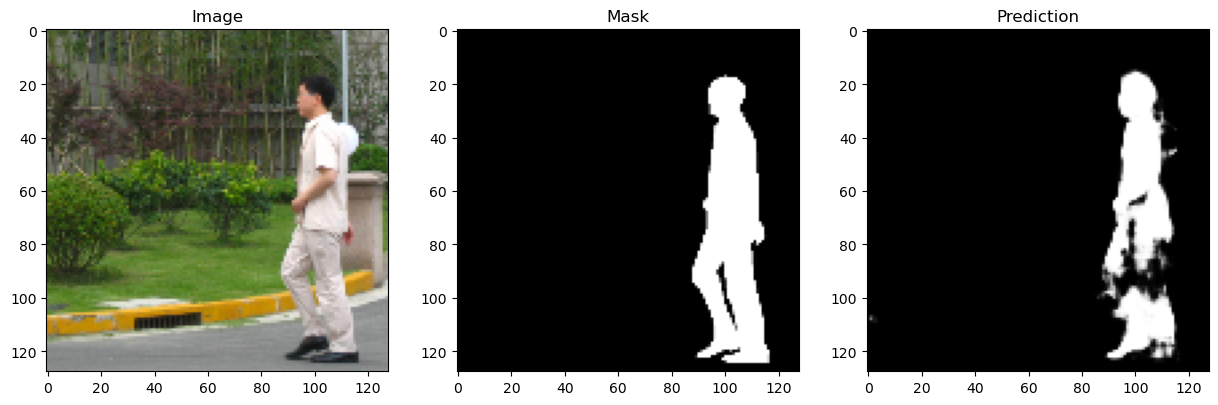

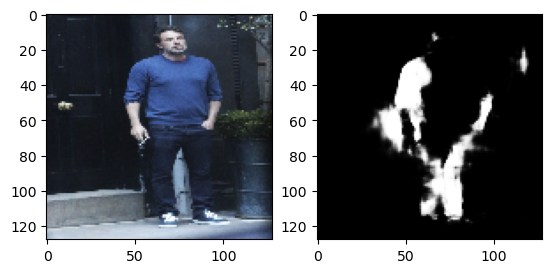

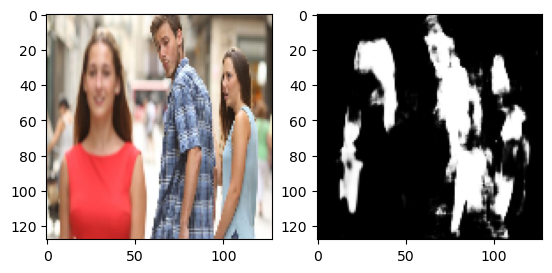

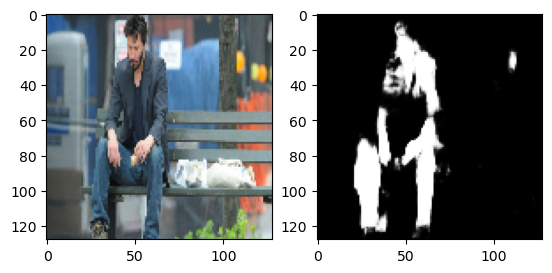

In [10]:
# Use the model on the test set and visualize the results
model.eval()
with torch.no_grad():
    image, mask = next(iter(test_loader))
    image = image.to(device)
    mask = mask.to(device)
    pred = model(image)
    pred = pred.cpu().numpy()
    mask = mask.cpu().numpy()
    image = image.cpu().numpy()
    pred = np.squeeze(pred, axis=1)
    fig, ax = plt.subplots(1, 3, figsize=(15, 15))
    ax[0].imshow(image[3].transpose(1, 2,0))
    ax[0].set_title("Image")
    ax[1].imshow(mask[3], cmap="gray")
    ax[1].set_title("Mask")
    ax[2].imshow(pred[3], cmap="gray")
    ax[2].set_title("Prediction")
    plt.show()

    for image in os.listdir("./out_of_distribution_images"):
        image = cv2.imread(os.path.join("./out_of_distribution_images", image))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (128, 128))
        image = image.transpose(2, 0, 1)
        image = image / 255
        image = torch.from_numpy(image).float()
        image = image.to(device)
        pred = model(image[None, ...])
        pred = pred.cpu().numpy()
        pred = np.squeeze(pred, axis=1)
        plt.subplot(1, 2, 1)
        plt.imshow(image.cpu().numpy().transpose(1, 2, 0))
        plt.subplot(1, 2, 2)
        plt.imshow(pred[0], cmap="gray")
        plt.show()

The model is trained for 40 epochs and the results are shown below. The model is able to detect the edges of the objects in the image and the mask. The model is not able to detect the objects completely. This is because the dataset is very small and the model is not able to learn the features of the objects. The model is also not able to detect the objects that are not present in the training set.


<a id='p1d'></a>
##### (d) Report training loss, validation loss, and validation DICE curves. Comment on any overfitting or underfitting observed.

[Table of Contents](#Table-of-Contents)

<a id='p2a'></a>
##### (e) Report the average dice score over your test-set. **You should be able to achieve a score of around 0.7 or better**.

[Table of Contents](#Table-of-Contents)

<a id='p2b'></a>
##### (f) Show at least 3 example segmentations (i.e. show the RGB image, mask, and RGB image X mask for 3 samples) from your training data and 3 from your testing data. Comment on the generalization capabilities of your trained network.

[Table of Contents](#Table-of-Contents)

<a id='p2c'></a>
##### (g) Show at least 1 example segmentation on an input image **<ins>not</ins> from the FudanPed dataset**. Again, comment on the generalization capabilities of your network with respect to this "out-of-distribution" image.

[Table of Contents](#Table-of-Contents)

In [9]:
# Create a README.md from this notebook
!jupyter nbconvert --TagRemovePreprocessor.enabled=True --TagRemovePreprocessor.remove_cell_tags run_all aaz7118-CA04.ipynb --to html --template lab
!jupyter nbconvert --TagRemovePreprocessor.enabled=True --TagRemovePreprocessor.remove_cell_tags run_all aaz7118-CA04.ipynb --to markdown --output README.md

[NbConvertApp] WARNING | Config option `kernel_spec_manager_class` not recognized by `NbConvertApp`.
[NbConvertApp] Converting notebook aaz7118-CA04.ipynb to html
[NbConvertApp] Writing 1398240 bytes to aaz7118-CA04.html
[NbConvertApp] WARNING | Config option `kernel_spec_manager_class` not recognized by `NbConvertApp`.
[NbConvertApp] Converting notebook aaz7118-CA04.ipynb to markdown
[NbConvertApp] Support files will be in README_files\
[NbConvertApp] Making directory README_files
[NbConvertApp] Writing 53574 bytes to README.md
